In [51]:
!python -m pip install pmdarima

In [52]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from datetime import datetime

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [53]:
train_test_ratio = 0.9

# ARIMA

In [10]:
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')
ads_de = pd.read_csv("ADS.DE.csv",index_col="Date",parse_dates = ['Date'],date_parser=dateparse)
pum_de = pd.read_csv("PUM.DE.csv",index_col="Date",parse_dates = ['Date'],date_parser=dateparse)
skx = pd.read_csv("skx.csv",index_col="Date",parse_dates = ['Date'],date_parser=dateparse)

In [11]:
train_test_ratio = 0.9

In [12]:
ads_de = ads_de.ffill(axis = 0)
pum_de = pum_de.ffill(axis = 0)
skx = skx.ffill(axis = 0)

In [15]:
df_close = pum_de['Close']

SyntaxError: invalid non-printable character U+0008 (1872505289.py, line 1)

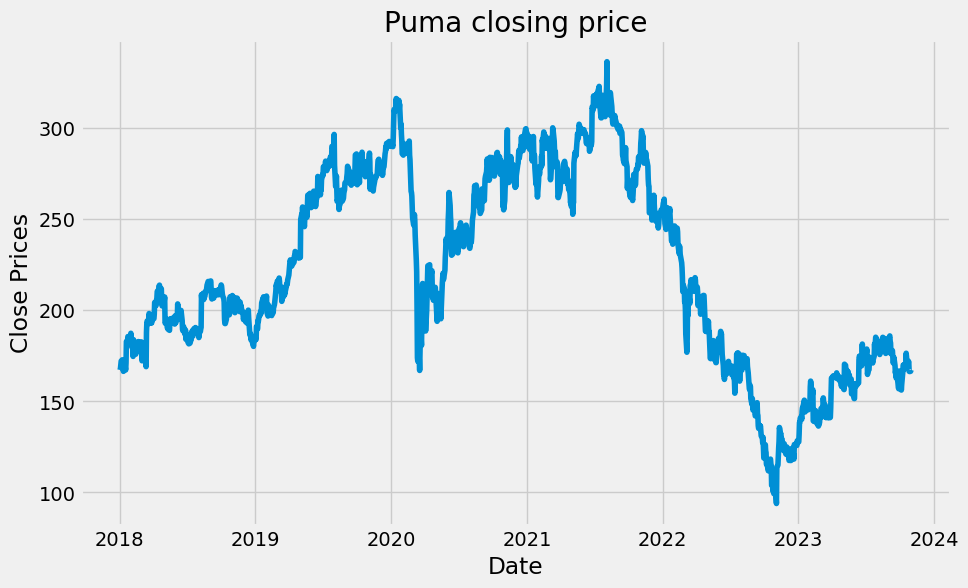

In [16]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_close)
plt.title('Puma closing price')
plt.show()

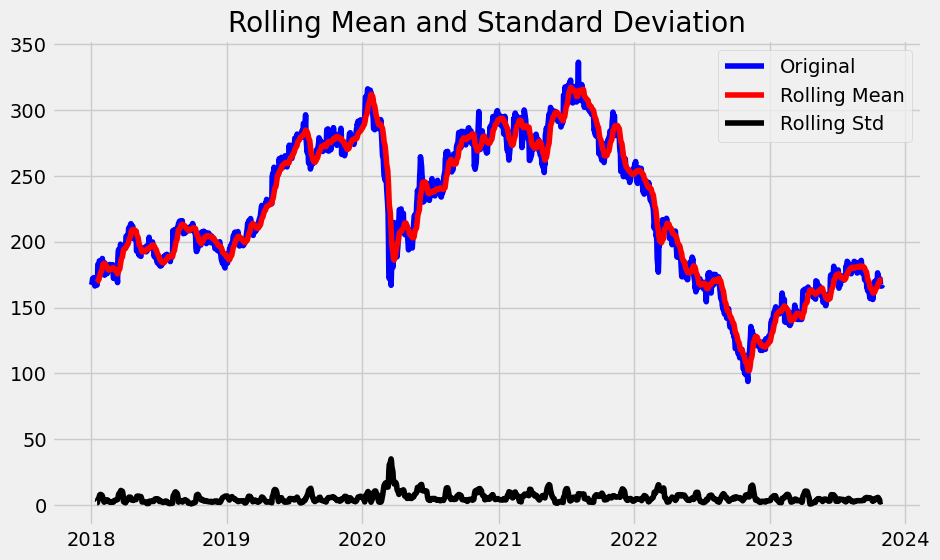

Results of dickey fuller test
Test Statistics                  -1.625502
p-value                           0.469846
No. of lags used                  7.000000
Number of observations used    1475.000000
critical value (1%)              -3.434791
critical value (5%)              -2.863501
critical value (10%)             -2.567814
dtype: float64


In [17]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

Based on the result of the dickey fuller test with a p-value greater than 0.05, we cannot reject the null hypothesis. The test statistics is also greater than the critical value at all three significance level. Therefore the data is non-stationary.

We proceed to separate Trend and Seasonality from the time series.

<Figure size 1000x600 with 0 Axes>

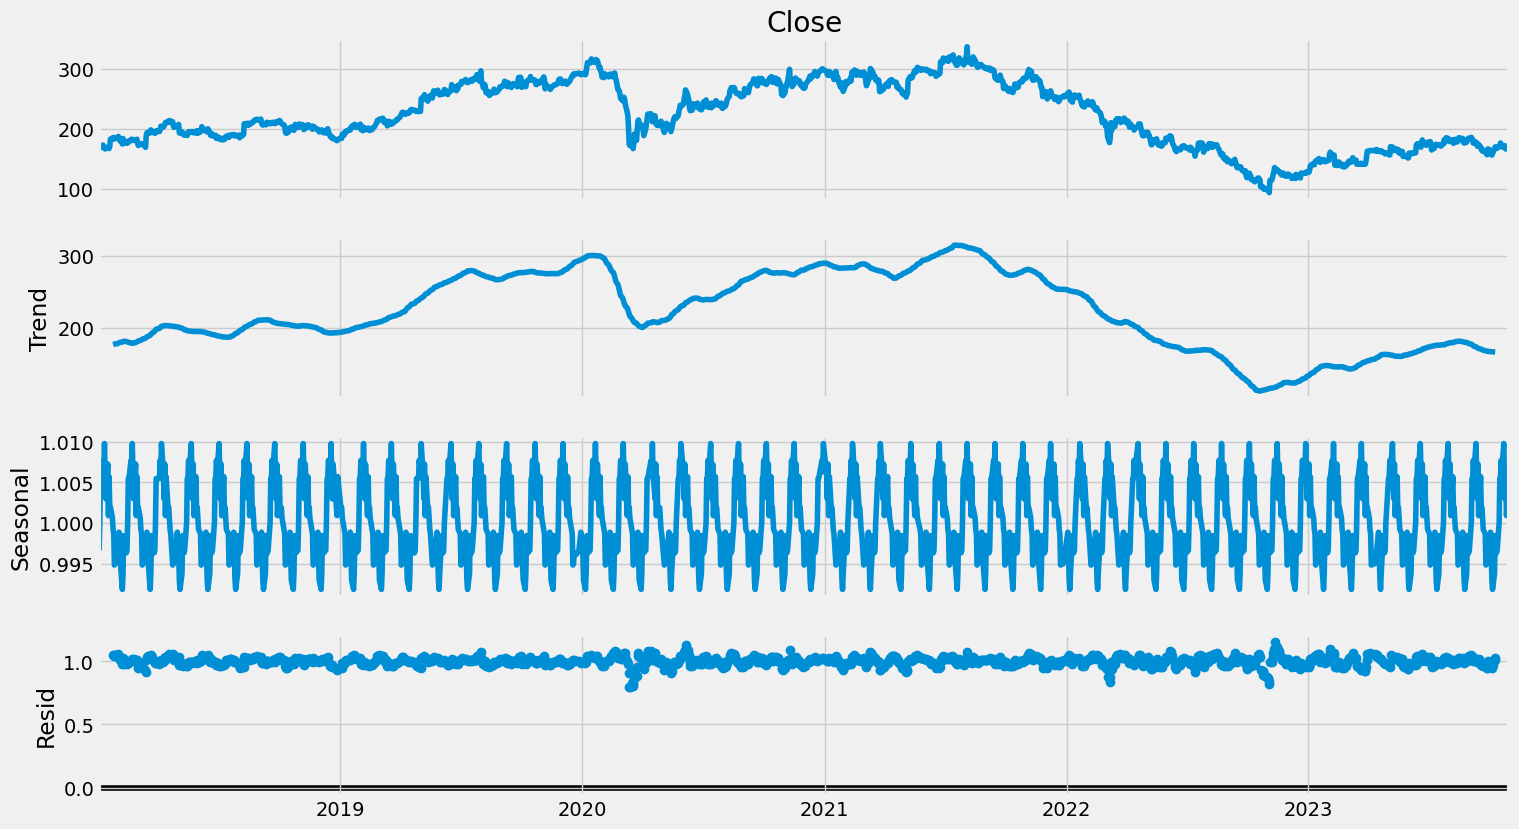

In [18]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


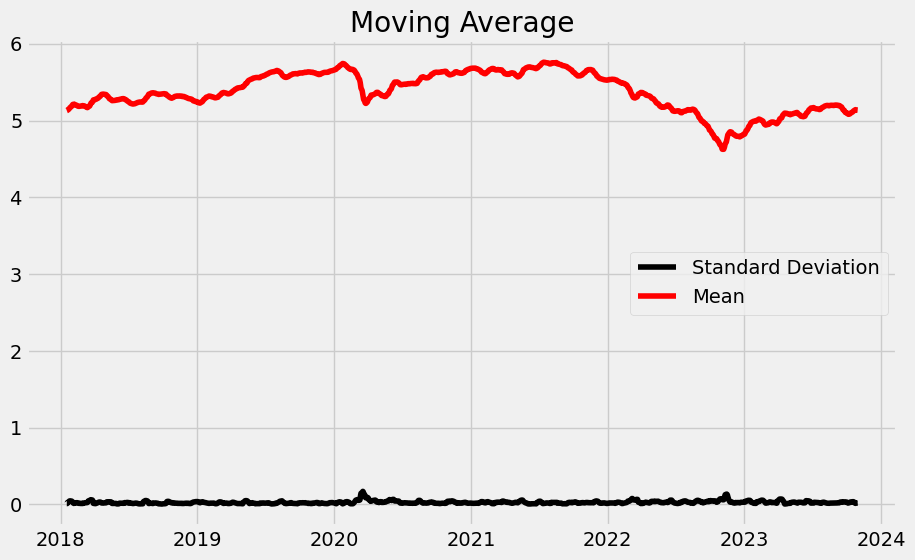

In [19]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Here we take the log to reduce the variation of the data to make it more stationary

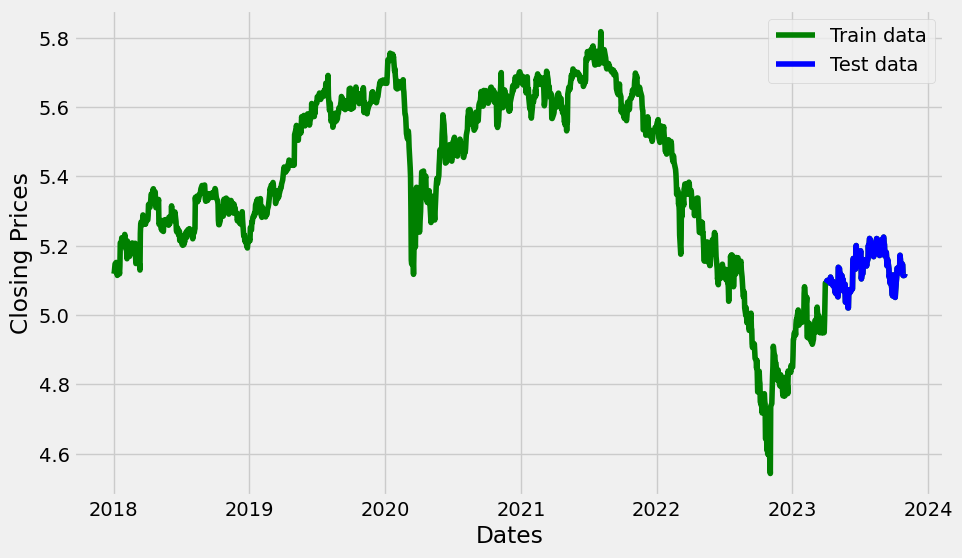

In [20]:
#split data into train and training set
train_data, test_data = df_log[:int(len(df_log)*train_test_ratio)], df_log[int(len(df_log)*train_test_ratio):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6364.338, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6362.752, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6362.753, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6366.337, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6360.757, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.867 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1334
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3184.168
Date:                Sun, 31 Dec 2023   AIC                          -6366.337
Time:                        13:53:01   BIC                          -6361.142
Sample:                             0   HQIC                         -6364.390
                               - 1334                                  

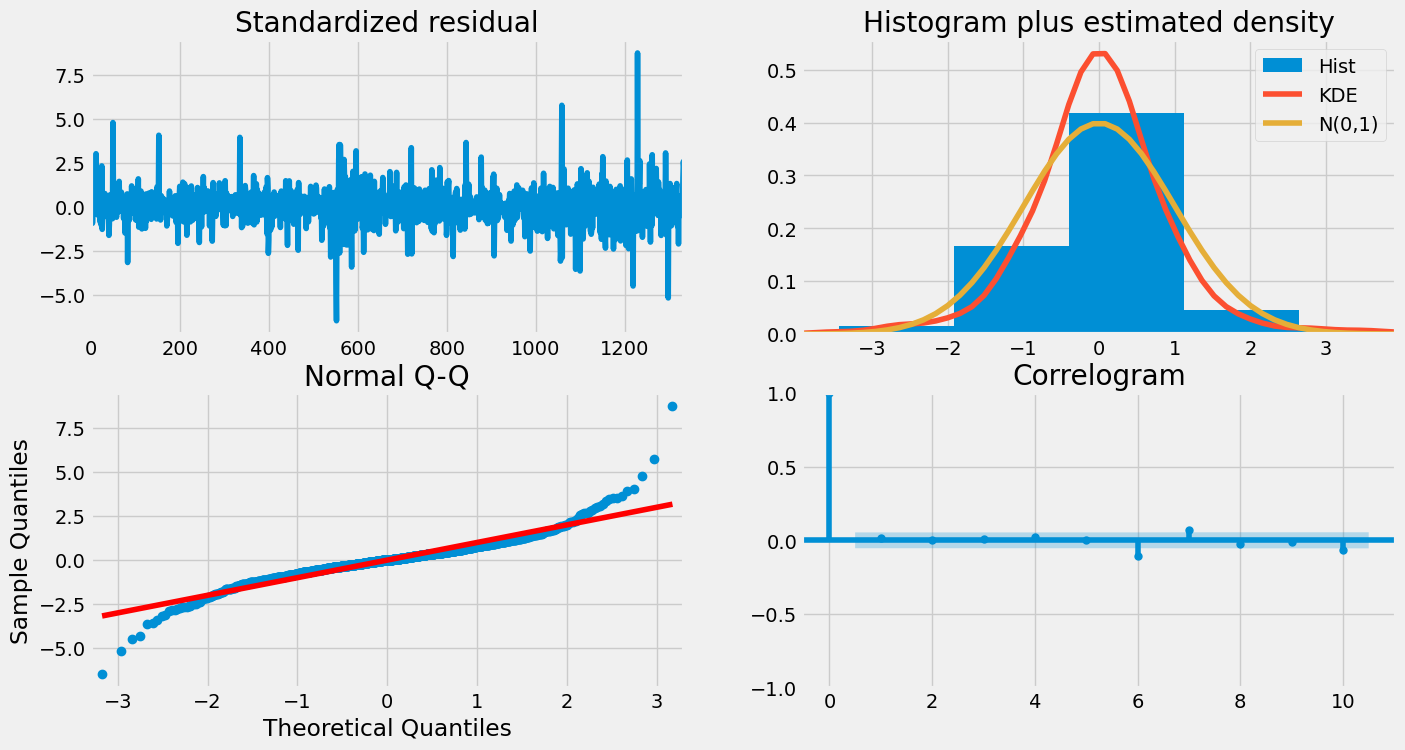

In [21]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [22]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(0,1,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1334
Model:                 ARIMA(0, 1, 0)   Log Likelihood                3184.168
Date:                Sun, 31 Dec 2023   AIC                          -6366.337
Time:                        13:53:02   BIC                          -6361.142
Sample:                             0   HQIC                         -6364.390
                               - 1334                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0005   8.27e-06     59.599      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):              4187.57
Prob(Q):                              0.52   Pr

In [23]:
# Forecast
fc = fitted.forecast(len(test_data)+30, alpha=0.05)  # 95% conf

In [24]:
test_data = test_data.reset_index()
test_data['Close'] = np.exp(test_data['Close'])

In [25]:
for i in range(30):
    next_date = test_data.iloc[-1,0] + timedelta(days=1)
    empty_df = pd.DataFrame({col: [""] for col in test_data.columns})
    test_data = pd.concat([test_data,empty_df])
    test_data.iloc[-1,0] = next_date
    

In [26]:
test_data = pd.DataFrame(test_data)
test_data['pred_price'] = np.exp(fc.values)
forecast_data = test_data [-30:]
test_data = test_data[:-30]


In [27]:
# report performance of ADS_DE
mse = mean_squared_error(test_data['Close'], test_data['pred_price'])
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data['Close'], test_data['pred_price'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data['Close'], test_data['pred_price']))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test_data['pred_price'] - test_data['Close'])/np.abs(test_data['Close']))
print('MAPE: '+str(mape))

MSE: 121.4508007256557
MAE: 8.875705570469776
RMSE: 11.020471892149432
MAPE: 0.05084429282795952


In [28]:
# report performance of PUM_DE
mse = mean_squared_error(test_data['Close'], test_data['pred_price'])
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data['Close'], test_data['pred_price'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data['Close'], test_data['pred_price']))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test_data['pred_price'] - test_data['Close'])/np.abs(test_data['Close']))
print('MAPE: '+str(mape))

MSE: 121.4508007256557
MAE: 8.875705570469776
RMSE: 11.020471892149432
MAPE: 0.05084429282795952


In [543]:
# report performance of SKX
mse = mean_squared_error(test_data['Close'], test_data['pred_price'])
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data['Close'], test_data['pred_price'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data['Close'], test_data['pred_price']))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test_data['pred_price'] - test_data['Close'])/np.abs(test_data['Close']))
print('MAPE: '+str(mape))

MSE: 43.16638517818727
MAE: 5.531609979591836
RMSE: 6.570113026287087
MAPE: 0.12256434059322048


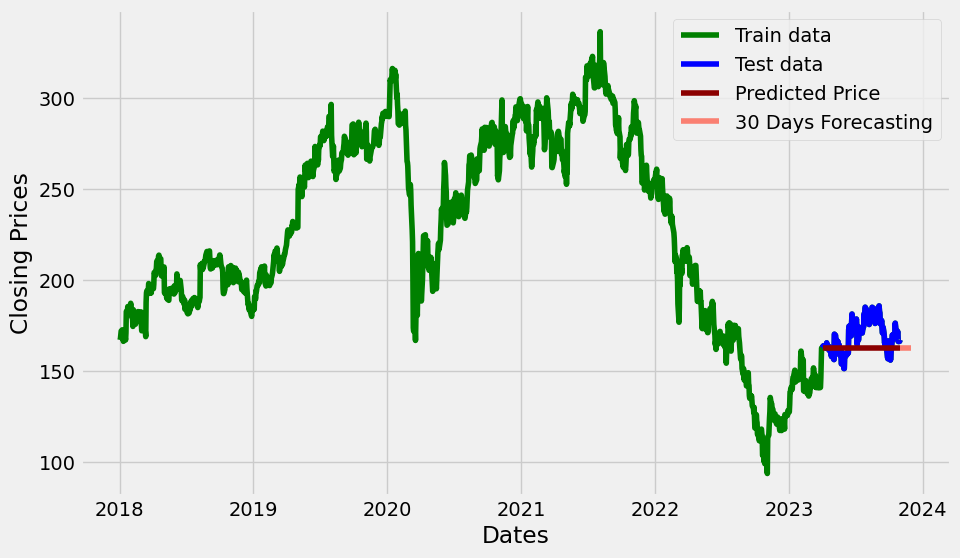

In [29]:
#ADS_DE
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(np.exp(df_log), 'green', label='Train data')
plt.plot(test_data.Date,test_data['Close'], 'blue', label='Test data')
plt.plot(test_data.Date,test_data['pred_price'],color = '#8B0000',  label = 'Predicted Price')
plt.plot(forecast_data.Date,forecast_data['pred_price'], color = 'salmon', label = "30 Days Forecasting")
plt.legend()

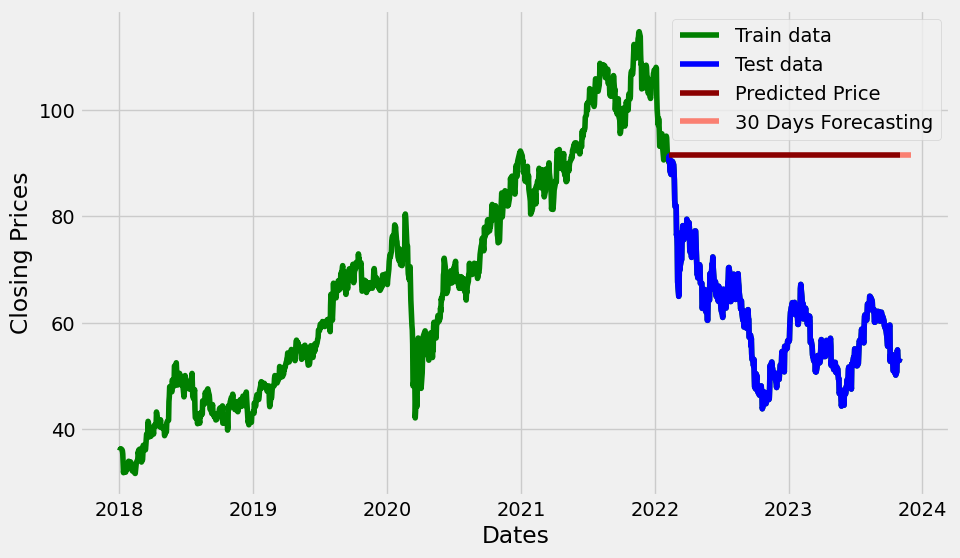

In [515]:
#Pum_de
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(np.exp(df_log), 'green', label='Train data')
plt.plot(test_data.Date,test_data['Close'], 'blue', label='Test data')
plt.plot(test_data.Date,test_data['pred_price'],color = '#8B0000',  label = 'Predicted Price')
plt.plot(forecast_data.Date,forecast_data['pred_price'], color = 'salmon', label = "30 Days Forecasting")
plt.legend()

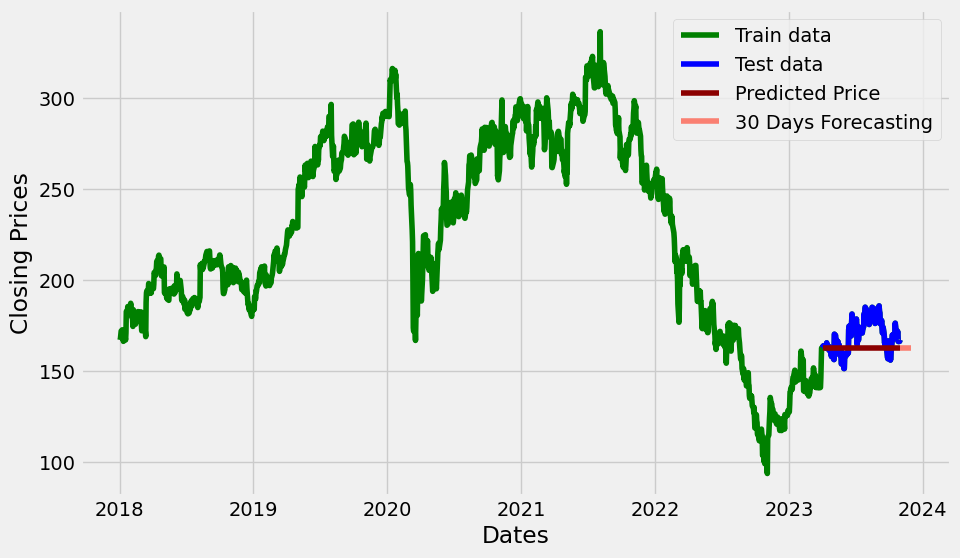

In [30]:
#SKX
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(np.exp(df_log), 'green', label='Train data')
plt.plot(test_data.Date,test_data['Close'], 'blue', label='Test data')
plt.plot(test_data.Date,test_data['pred_price'],color = '#8B0000',  label = 'Predicted Price')
plt.plot(forecast_data.Date,forecast_data['pred_price'], color = 'salmon', label = "30 Days Forecasting")
plt.legend()

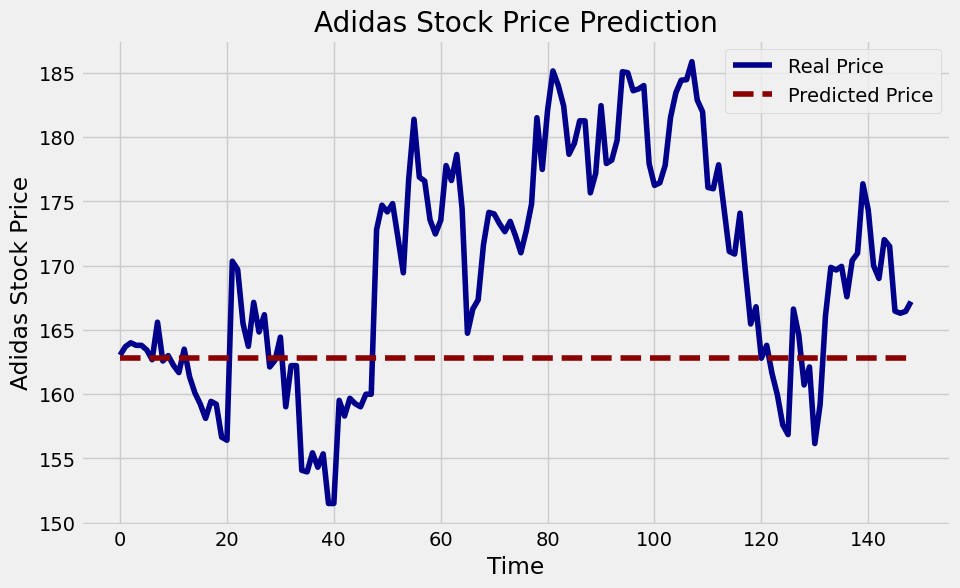

In [31]:
plt.plot(test_data['Close'],color = '#00008B', label = 'Real Price')
plt.plot(test_data['pred_price'], color = '#8B0000', linestyle='--', label = 'Predicted Price')
plt.title('Adidas Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Adidas Stock Price')
plt.legend()
plt.show()

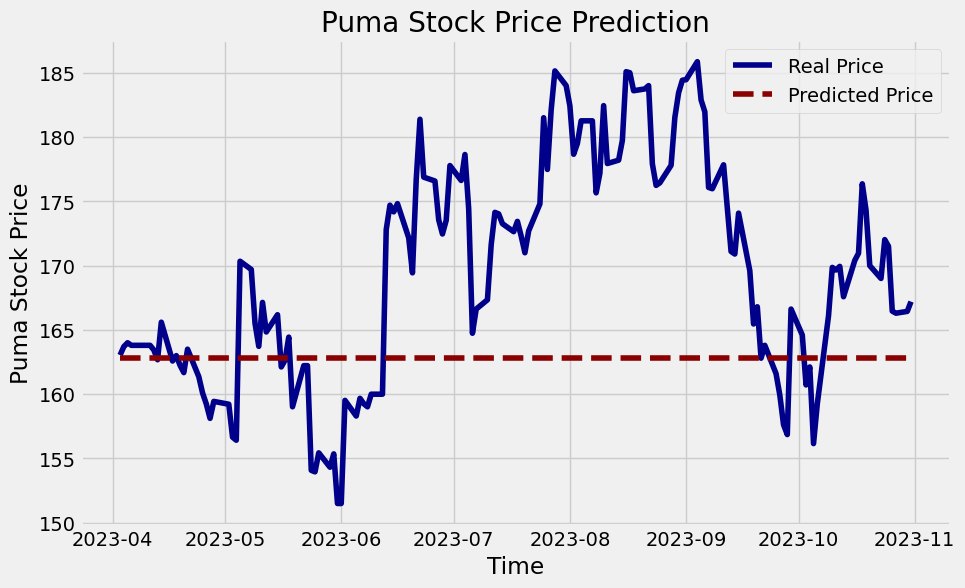

In [32]:
plt.plot(test_data.Date,test_data['Close'],color = '#00008B', label = 'Real Price')
plt.plot(test_data.Date,test_data['pred_price'], color = '#8B0000', linestyle='--', label = 'Predicted Price')
plt.title('Puma Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Puma Stock Price')
plt.legend()
plt.show()

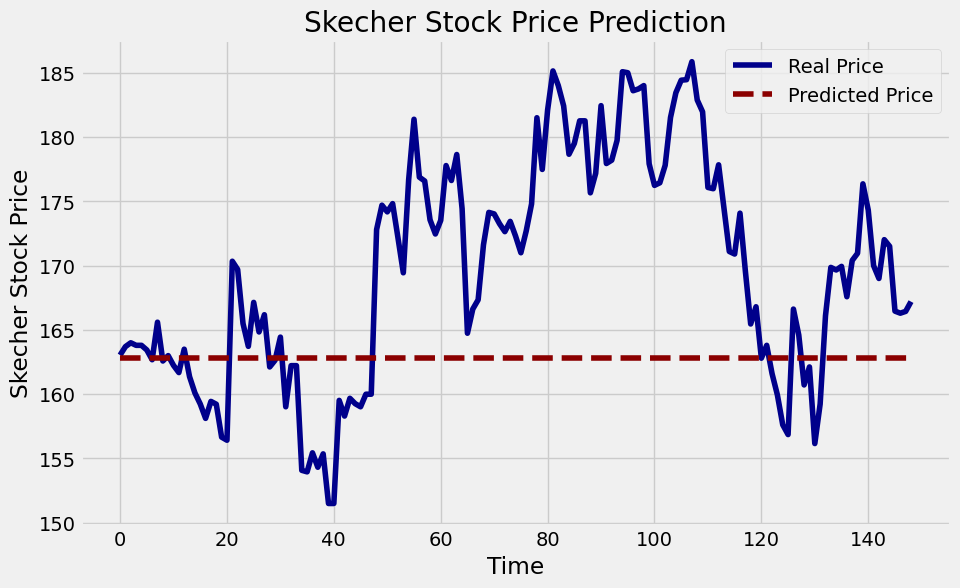

In [33]:
plt.plot(test_data['Close'],color = '#00008B', label = 'Real Price')
plt.plot(test_data['pred_price'], color = '#8B0000', linestyle='--', label = 'Predicted Price')
plt.title('Skecher Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Skecher Stock Price')
plt.legend()
plt.show()

From all three examples, the ARIMA model find the stock price to be a random walk. Therefore the ARIMA model predict only a fix value, which is not really useful in practice.

# RNN

In [34]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import timedelta

In [35]:
# Load data
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')
ads_de = pd.read_csv("ADS.DE.csv",index_col="Date",parse_dates = ['Date'],date_parser=dateparse)
pum_de = pd.read_csv("PUM.DE.csv",index_col="Date",parse_dates = ['Date'],date_parser=dateparse)
skx = pd.read_csv("skx.csv",index_col="Date",parse_dates = ['Date'],date_parser=dateparse)
ads_de = ads_de.ffill(axis = 0)
pum_de = pum_de.ffill(axis = 0)
skx = skx.ffill(axis = 0)

In [36]:

windows_frame = 60

In [37]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema']-dataset['26ema']

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(window = 21).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Close']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    return dataset
def gen_data_split_train_test(data):
    data = get_technical_indicators(data)
    data = data.dropna()
    train_data, test_data = data[:int(len(data)*train_test_ratio)], data[int(len(data)*train_test_ratio):]
    return train_data,test_data


We created additional features using several usual technical indicators.

In [38]:
data = ads_de
train_data,test_data = gen_data_split_train_test(data)
feature_list = ['Close','ma7', 'ma21',
       '26ema', '12ema', 'MACD', '20sd', 'upper_band', 'lower_band', 'ema',
       'momentum', 'log_momentum']
feature_list_wo_close = [ 'ma7', 'ma21',
       '26ema', '12ema', 'MACD', '20sd', 'upper_band', 'lower_band', 'ema',
       'momentum', 'log_momentum']
train_set = train_data[feature_list]
features = train_set.shape[1]

In [39]:
sc = MinMaxScaler(feature_range = (0, 1))
sc_single = MinMaxScaler(feature_range = (0, 1))
training_scaled = np.concatenate([sc.fit_transform(train_set[feature_list_wo_close]),sc_single.fit_transform(train_set[['Close']])],axis=1)

We also scale the data using a MinMaxScaler.

In [40]:
x_train = []
y_train = []
for i in range(windows_frame,train_set.shape[0]):
    x_train.append(training_scaled[i-windows_frame:i])
    y_train.append(training_scaled[i,0])
x_train,y_train = np.array(x_train),np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],features))

- We have train data composed of stock Close prices over days
- My aim is to predict the Close price of the next day.
- I can use a time step of 60 days.
- I will pick first 60 open prices (0 to 60), 1st 60 price will be in X_train data
- Then predict the price of 61th day; and 61th price will be in y_train data
- Again, I will pick prices from 1 to 61, those will be in X_train data
- Then predict the next days price, 62nd price will be in y_train data



In [41]:
# initializing the RNN
regressor = Sequential()
# adding first RNN layer and dropout regulatization
regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (x_train.shape[1],features))
             )
regressor.add(
    Dropout(0.2)
             )
# adding second RNN layer and dropout regulatization
regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )
regressor.add(
    Dropout(0.2)
             )
# adding third RNN layer and dropout regulatization
regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )
regressor.add(
    Dropout(0.2)
             )
# adding fourth RNN layer and dropout regulatization
regressor.add(
    SimpleRNN(units = 50)
             )
regressor.add(
    Dropout(0.2)
             )
# adding the output layer
regressor.add(Dense(units = 1))
# compiling RNN
regressor.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

In [42]:
regressor.fit(x_train,y_train,epochs = 100, batch_size = 32)

Epoch 1/100


2023-12-31 13:54:05.693853: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


40/40 [==============================] - 2s 21ms/step - loss: 0.3826 - accuracy: 7.9618e-04
Epoch 2/100
40/40 [==============================] - 1s 19ms/step - loss: 0.2327 - accuracy: 7.9618e-04
Epoch 3/100
40/40 [==============================] - 1s 20ms/step - loss: 0.1838 - accuracy: 7.9618e-04
Epoch 4/100
40/40 [==============================] - 1s 21ms/step - loss: 0.1360 - accuracy: 0.0016
Epoch 5/100
40/40 [==============================] - 1s 21ms/step - loss: 0.1036 - accuracy: 7.9618e-04
Epoch 6/100
40/40 [==============================] - 1s 21ms/step - loss: 0.1020 - accuracy: 0.0016
Epoch 7/100
40/40 [==============================] - 1s 21ms/step - loss: 0.0745 - accuracy: 0.0016
Epoch 8/100
40/40 [==============================] - 1s 21ms/step - loss: 0.0664 - accuracy: 0.0016
Epoch 9/100
40/40 [==============================] - 1s 21ms/step - loss: 0.0538 - accuracy: 0.0016
Epoch 10/100
40/40 [==============================] - 1s 21ms/step - loss: 0.0458 - accuracy: 0.

In [44]:
# Create test data and predict the stock price
real_price = test_data.iloc[:,3:4].values
dataset_total = pd.concat((train_data[feature_list],test_data[feature_list]),axis = 0)
inputs = dataset_total[len(dataset_total) - len(test_data)-windows_frame:]
inputs
inputs = np.concatenate([sc.fit_transform(inputs[feature_list_wo_close]),sc_single.fit_transform(inputs[['Close']])],axis=1)
x_test = []
for i in range(windows_frame,len(inputs)):
    x_test.append(inputs[i-windows_frame:i])
x_test = np.array(x_test)
x_test.shape
predicted_price = regressor.predict(x_test)
predicted_price = sc_single.inverse_transform(predicted_price)
predicted_price

5/5 [==============================] - 0s 4ms/step


array([[156.6843 ],
       [162.27101],
       [166.7615 ],
       [168.71942],
       [169.11833],
       [168.73746],
       [168.02652],
       [167.1712 ],
       [166.3239 ],
       [165.2669 ],
       [164.52591],
       [164.10794],
       [163.96222],
       [163.60666],
       [162.86963],
       [161.84236],
       [160.83104],
       [160.09467],
       [159.653  ],
       [159.26633],
       [159.53368],
       [161.7982 ],
       [165.33345],
       [167.99223],
       [169.73862],
       [170.58313],
       [170.40134],
       [169.62341],
       [168.36182],
       [167.01288],
       [165.54254],
       [163.92482],
       [162.66536],
       [162.07562],
       [161.05644],
       [159.42108],
       [157.97887],
       [156.83409],
       [156.16858],
       [155.60916],
       [155.2887 ],
       [155.29552],
       [156.33876],
       [158.03738],
       [159.91797],
       [161.05463],
       [161.31023],
       [162.08385],
       [165.07094],
       [169.20663],


In [45]:
test_plot_data = test_data.iloc[:,3:4]
test_plot_data['Close_pred'] = predicted_price

In [46]:
forecast_dfs = test_data[-60:][feature_list].reset_index()
for i in range(30):
    print(i)
    forecast_df = forecast_dfs[-60:]
    forecast_input = np.concatenate([sc.fit_transform(forecast_df[feature_list_wo_close]),sc_single.fit_transform(forecast_df[['Close']])],axis=1)
    forecast_inputs = []
    forecast_inputs.append(forecast_input)
    forecast_inputs = np.array(forecast_inputs)
    predicted_price = regressor.predict(forecast_inputs)
    predicted_price = sc_single.inverse_transform(predicted_price)
    # Create empty DataFrame with empty rows
    new_date = (forecast_dfs['Date'][-1:] + timedelta(days=1)).values[0]
    empty_data = {col: [''] for col in forecast_dfs.columns}
    empty_df = pd.DataFrame(empty_data)
    forecast_dfs = pd.concat([forecast_dfs,empty_df])
    # Fill in new row
    forecast_dfs.iloc[-1,0] = pd.Timestamp(new_date)
    forecast_dfs.iloc[-1,1] = predicted_price[0][0]
    forecast_dfs.iloc[-1,2] = forecast_dfs['Close'].rolling(window=7).mean()[-1:].values[0]
    forecast_dfs.iloc[-1,3] = forecast_dfs['Close'].rolling(window=21).mean()[-1:].values[0]
    forecast_dfs.iloc[-1,4] = forecast_dfs['Close'].ewm(span=26).mean()[-1:].values[0]
    forecast_dfs.iloc[-1,5] = forecast_dfs['Close'].ewm(span=12).mean()[-1:].values[0]
    forecast_dfs['MACD'] = forecast_dfs['12ema']-forecast_dfs['26ema']
    forecast_dfs.iloc[-1,7] = forecast_dfs['Close'].rolling(window = 21).std()[-1:].values[0]
    forecast_dfs['upper_band'] = forecast_dfs['ma21'] + (forecast_dfs['20sd']*2)
    forecast_dfs['lower_band'] = forecast_dfs['ma21'] - (forecast_dfs['20sd']*2)
    forecast_dfs.iloc[-1,10] = forecast_dfs['Close'].ewm(com=0.5).mean()[-1:].values[0]
    forecast_dfs['momentum'] = forecast_dfs['Close']-1
    forecast_dfs['log_momentum'] = np.log(forecast_dfs['momentum'].astype('float'))


0
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 12ms/step
2
1/1 [==============================] - 0s 11ms/step
3
1/1 [==============================] - 0s 13ms/step
4
1/1 [==============================] - 0s 12ms/step
5
1/1 [==============================] - 0s 11ms/step
6
1/1 [==============================] - 0s 12ms/step
7
1/1 [==============================] - 0s 11ms/step
8
1/1 [==============================] - 0s 11ms/step
9
1/1 [==============================] - 0s 12ms/step
10
1/1 [==============================] - 0s 10ms/step
11
1/1 [==============================] - 0s 12ms/step
12
1/1 [==============================] - 0s 12ms/step
13
1/1 [==============================] - 0s 11ms/step
14
1/1 [==============================] - 0s 11ms/step
15
1/1 [==============================] - 0s 11ms/step
16
1/1 [==============================] - 0s 11ms/step
17
1/1 [==============================] - 0s 12ms/step
18
1/1 [============

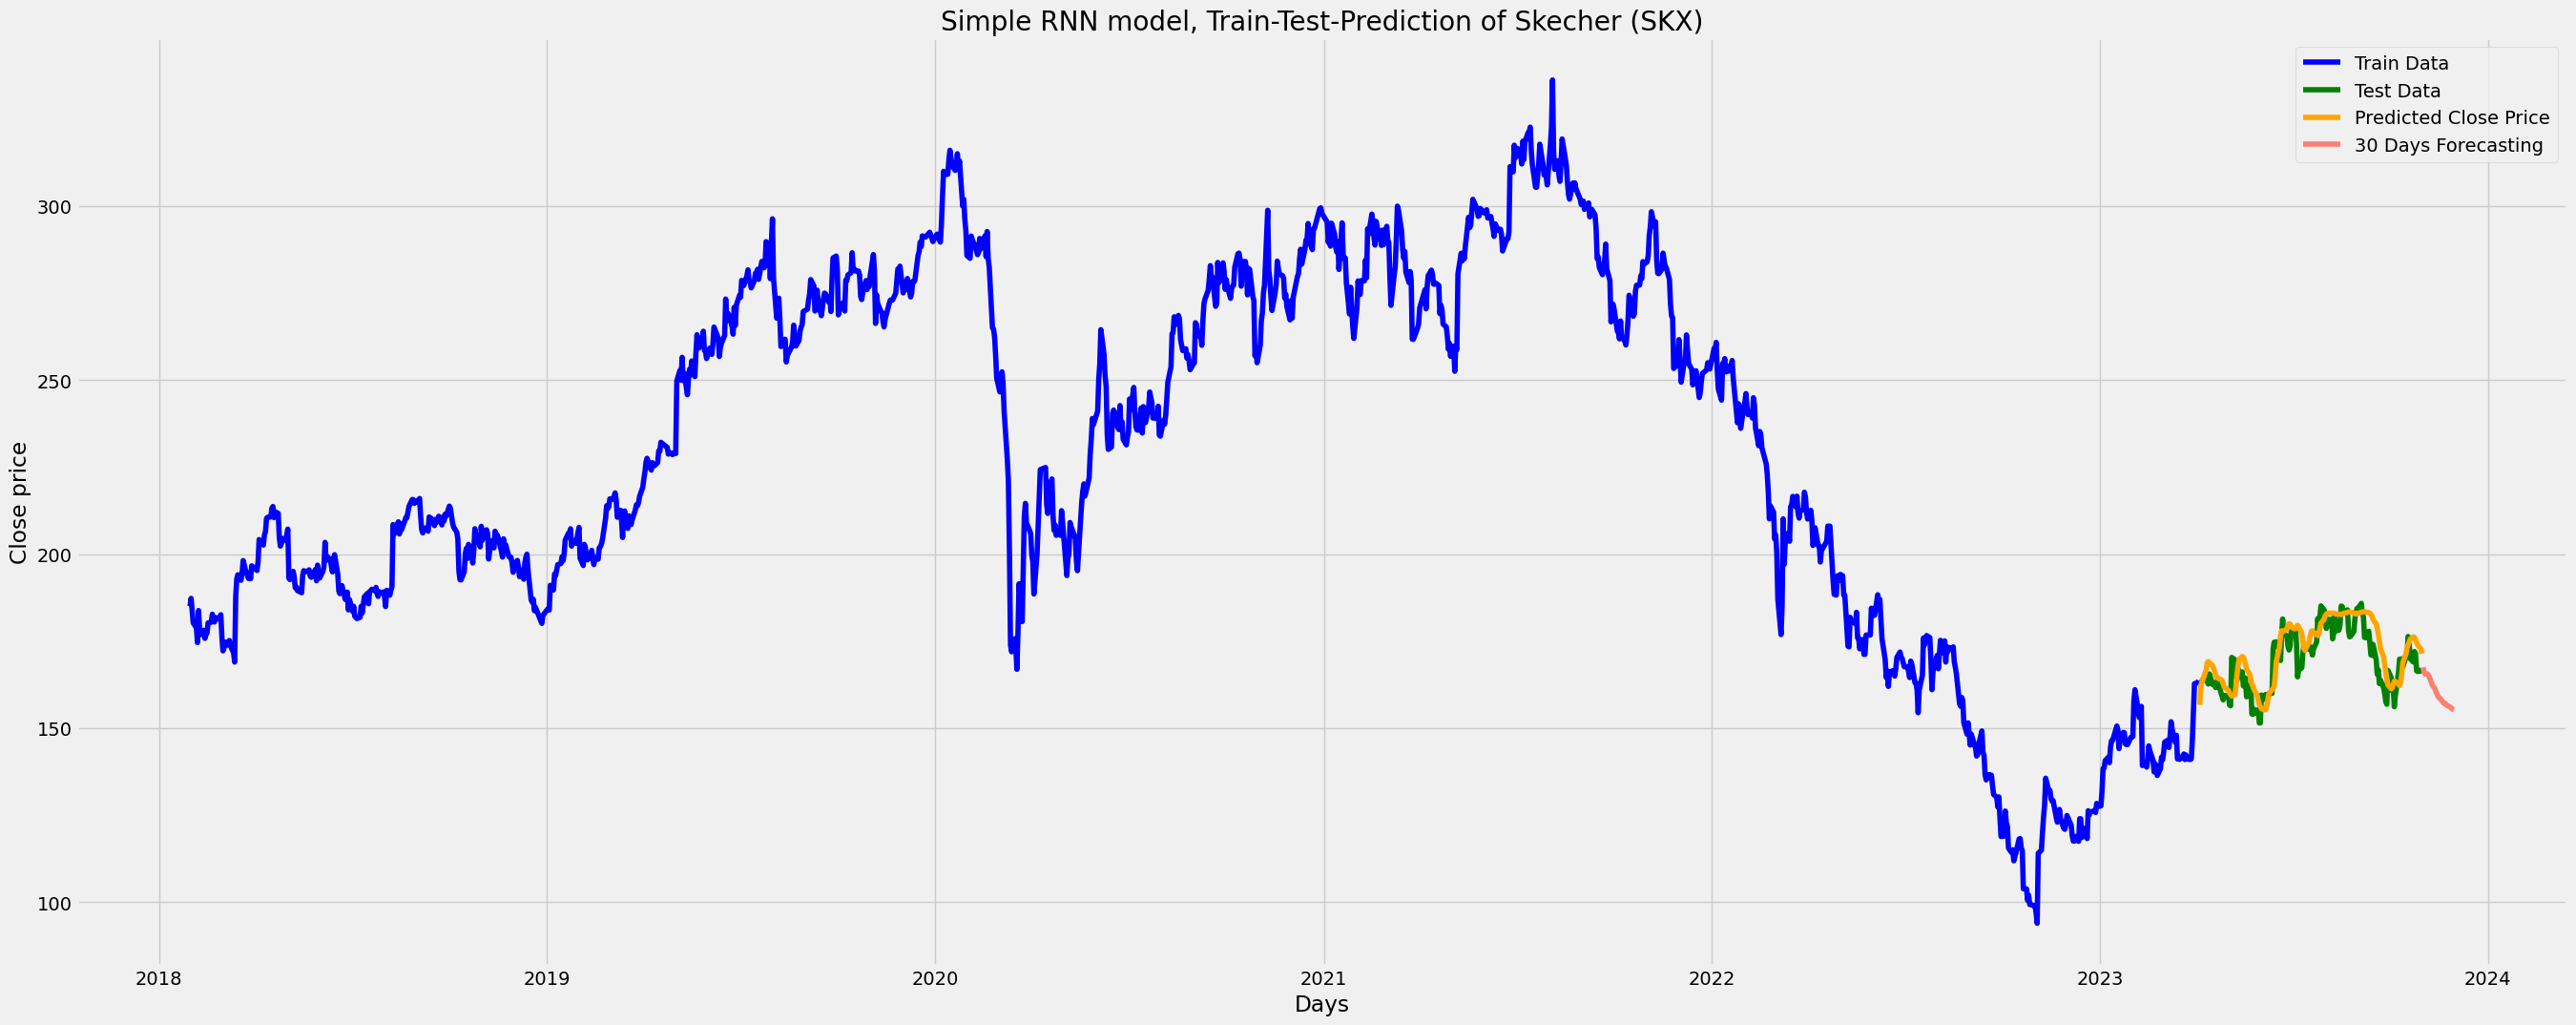

In [47]:
# Visualisation
plt.subplots(figsize =(30,12))
plt.plot(train_data.index, train_data.Close, label = "Train Data", color = "b")
plt.plot(test_data.index, test_data.Close, label = "Test Data", color = "g")
#plt.plot(train_data.Date.iloc[time_step:], y_pred, label = "y_pred", color = "r")
plt.plot(test_plot_data.index, test_plot_data.Close_pred, label = "Predicted Close Price", color = "orange")
plt.plot(forecast_dfs.Date[-30:],forecast_dfs.Close[-30:], label = "30 Days Forecasting",color = "salmon")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("Simple RNN model, Train-Test-Prediction of Skecher (SKX)")
plt.legend()
plt.show()



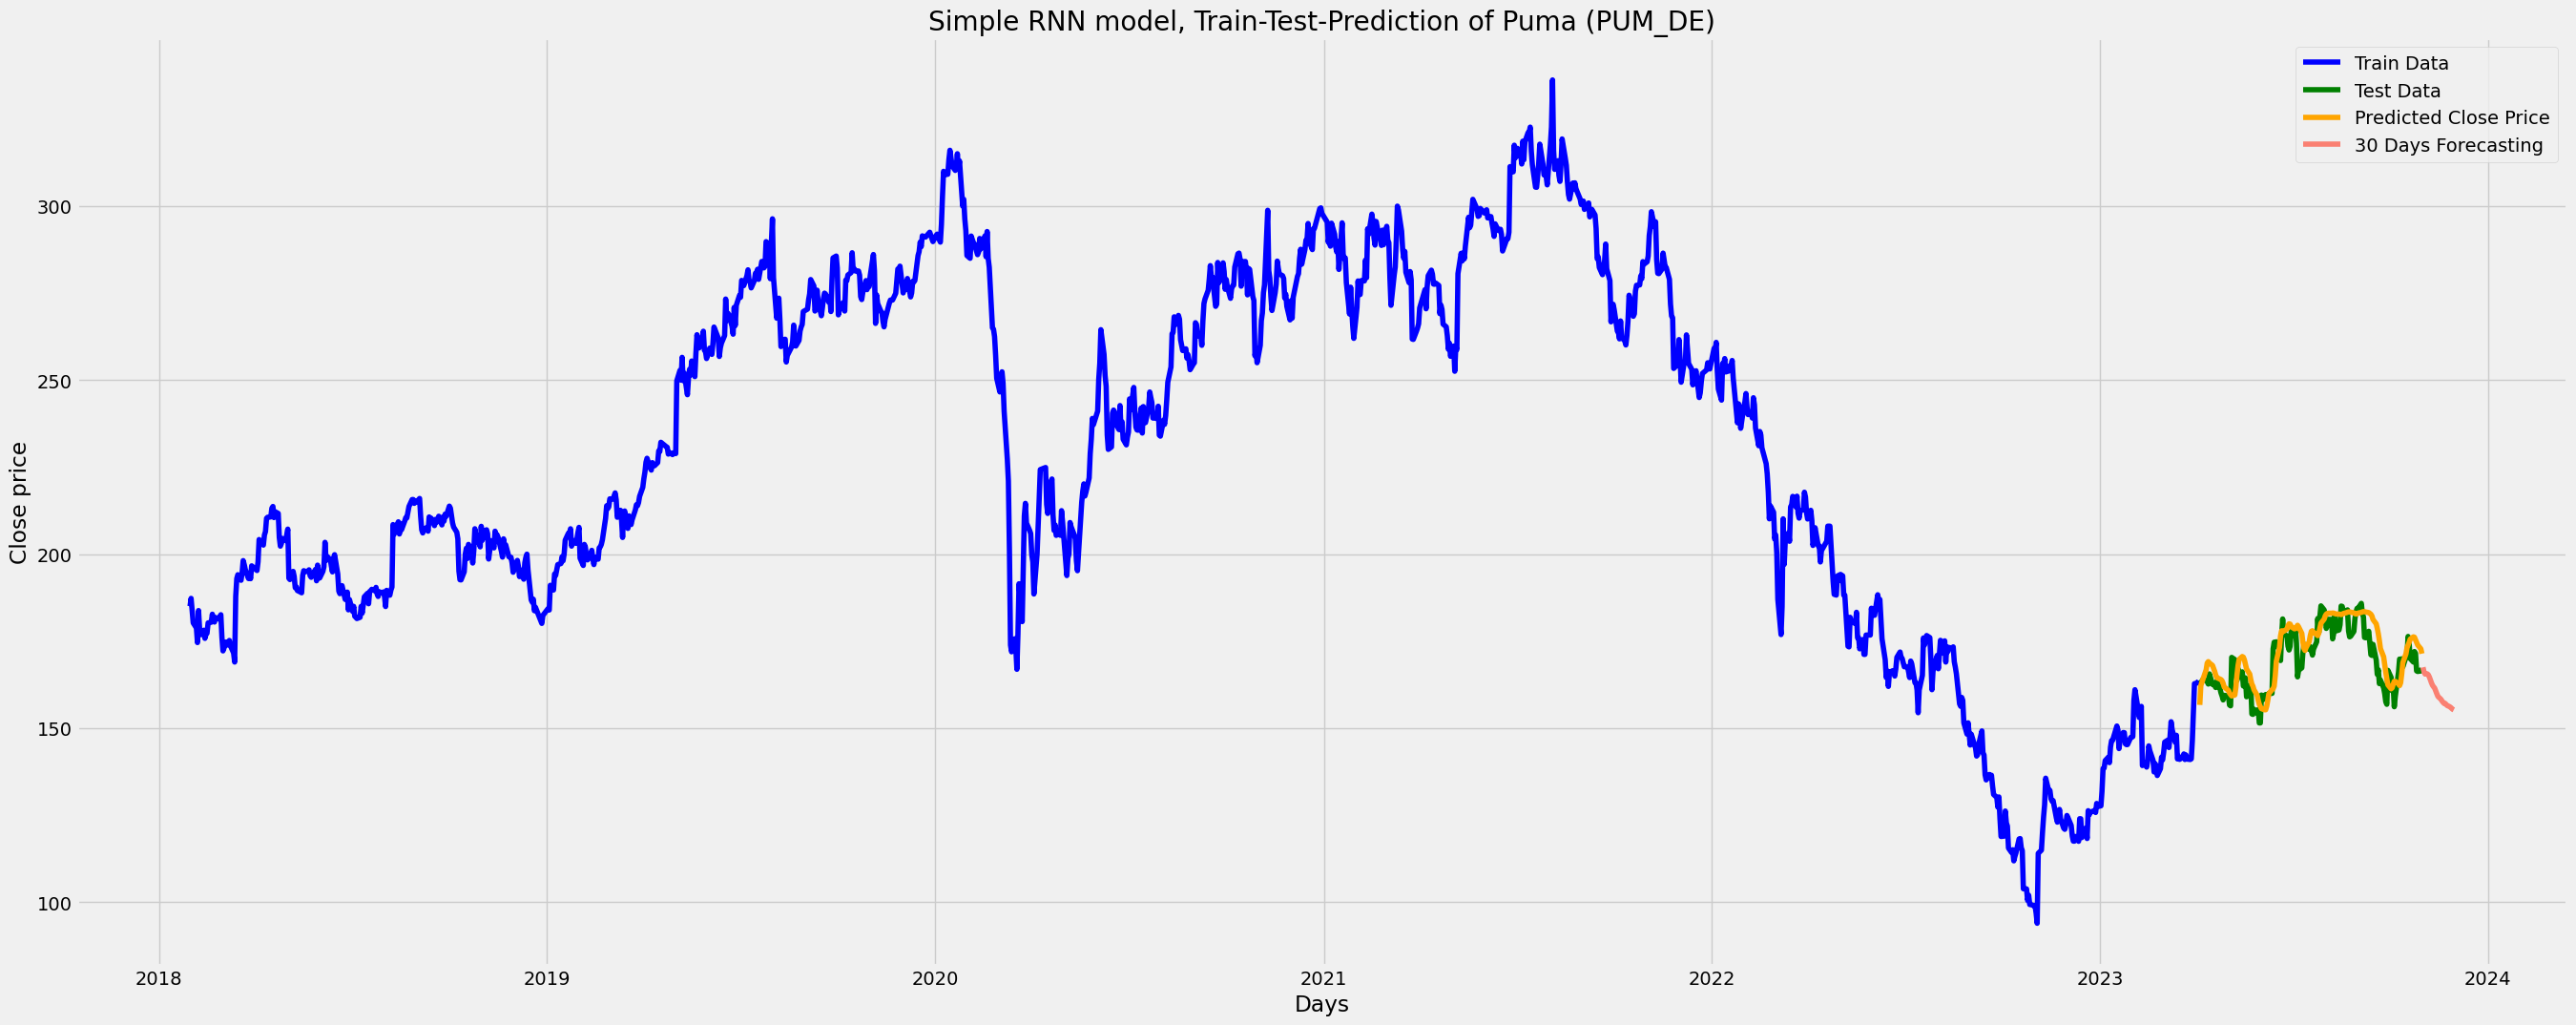

In [48]:
# Visualisation
plt.subplots(figsize =(30,12))
plt.plot(train_data.index, train_data.Close, label = "Train Data", color = "b")
plt.plot(test_data.index, test_data.Close, label = "Test Data", color = "g")
#plt.plot(train_data.Date.iloc[time_step:], y_pred, label = "y_pred", color = "r")
plt.plot(test_plot_data.index, test_plot_data.Close_pred, label = "Predicted Close Price", color = "orange")
plt.plot(forecast_dfs.Date[-30:],forecast_dfs.Close[-30:], label = "30 Days Forecasting",color = "salmon")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("Simple RNN model, Train-Test-Prediction of Puma (PUM_DE)")
plt.legend()
plt.show()



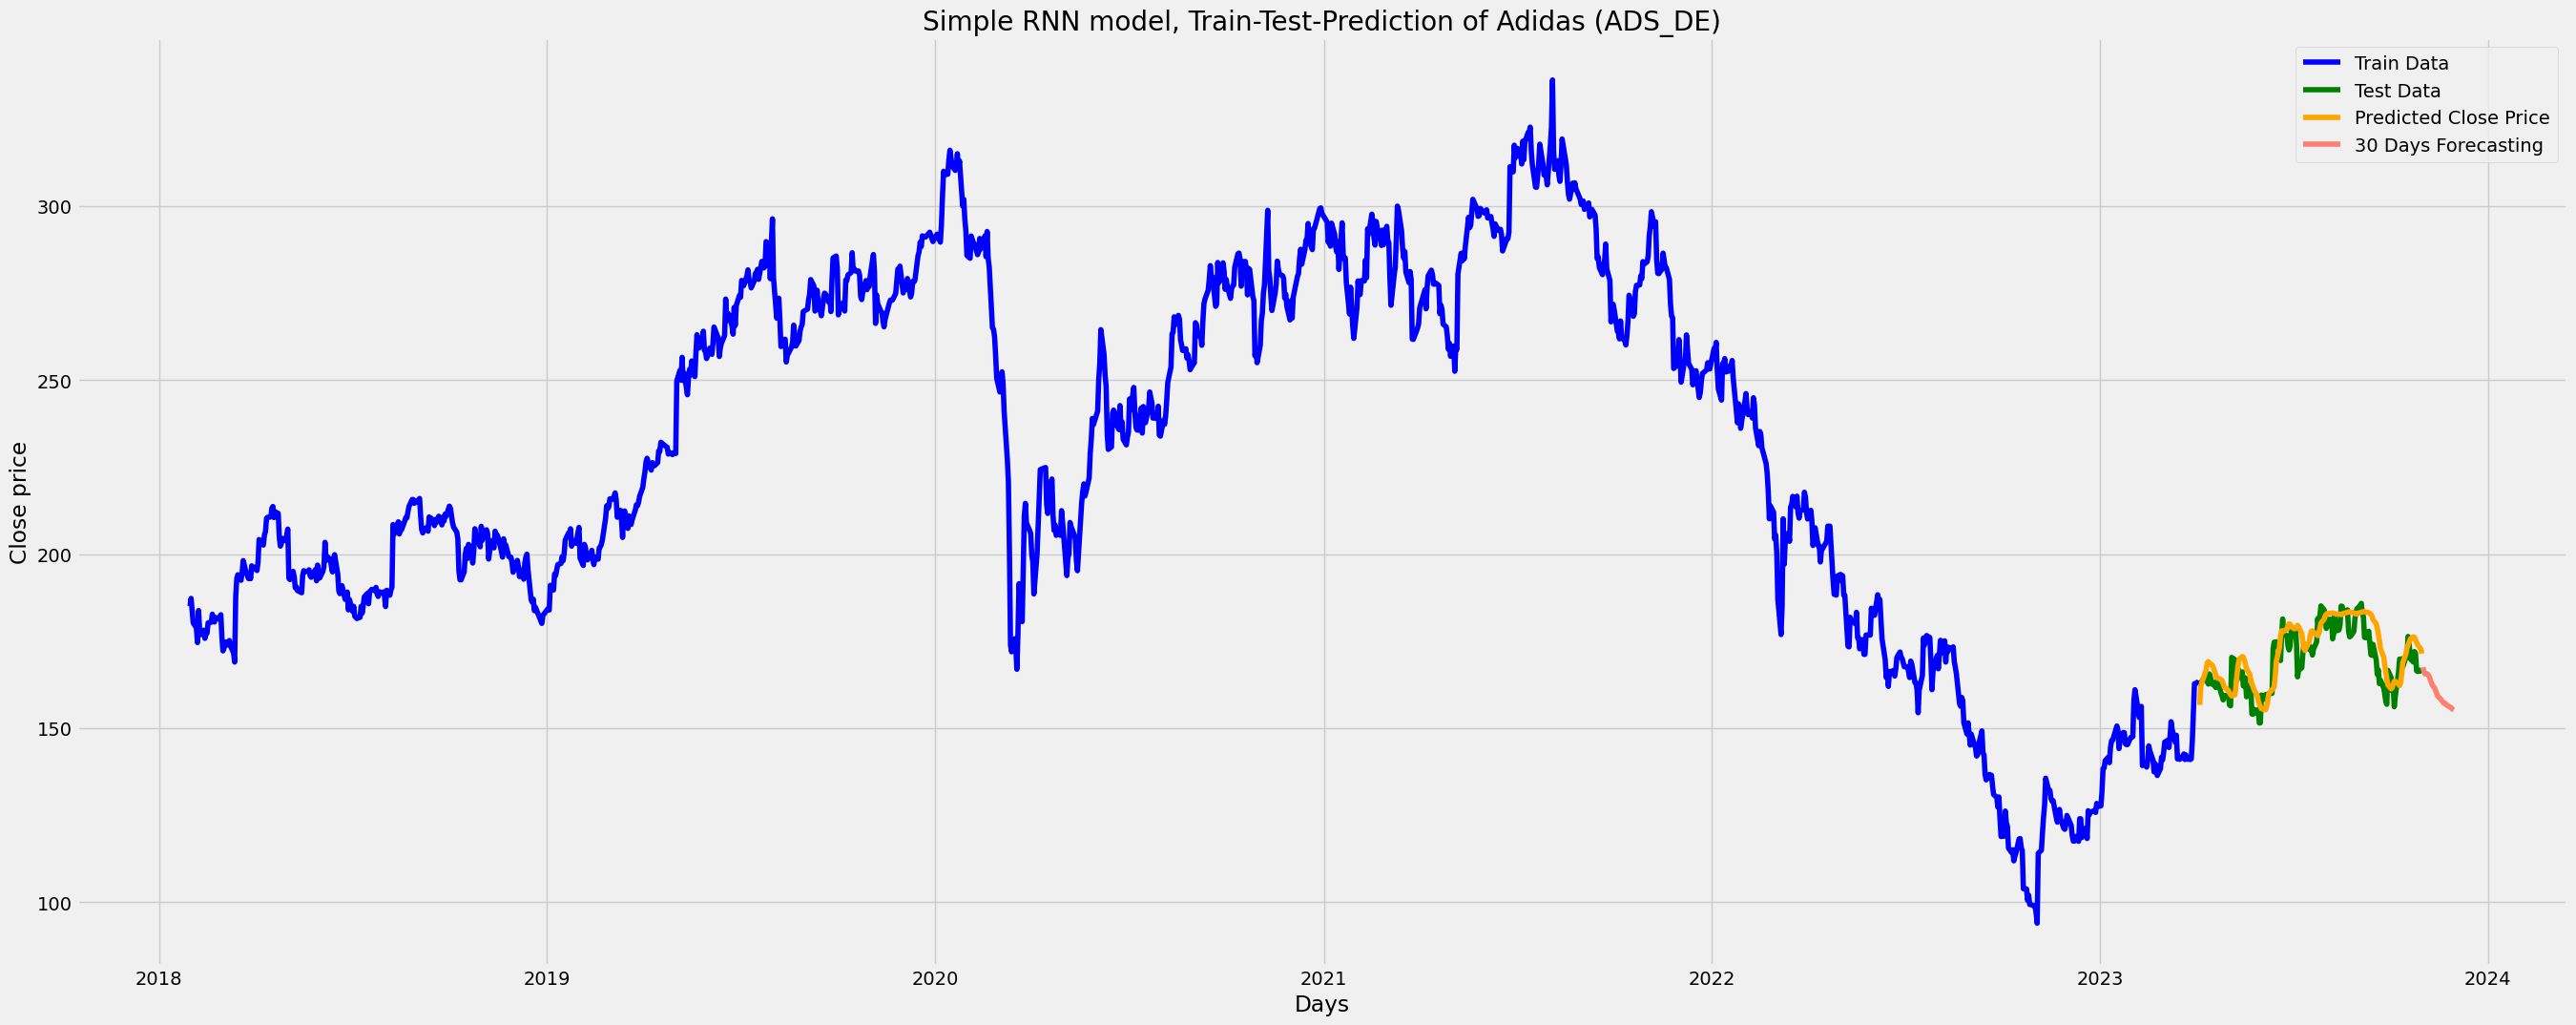

In [49]:
# Visualisation
plt.subplots(figsize =(30,12))
plt.plot(train_data.index, train_data.Close, label = "Train Data", color = "b")
plt.plot(test_data.index, test_data.Close, label = "Test Data", color = "g")
#plt.plot(train_data.Date.iloc[time_step:], y_pred, label = "y_pred", color = "r")
plt.plot(test_plot_data.index, test_plot_data.Close_pred, label = "Predicted Close Price", color = "orange")
plt.plot(forecast_dfs.Date[-30:],forecast_dfs.Close[-30:], label = "30 Days Forecasting",color = "salmon")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("Simple RNN model, Train-Test-Prediction of Adidas (ADS_DE)")
plt.legend()
plt.show()



In [50]:
# report performance of ADS_DE
mse = mean_squared_error(real_price, predicted_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_price, predicted_price)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(real_price, predicted_price))
print('RMSE: '+str(rmse))

ValueError: Found input variables with inconsistent numbers of samples: [147, 1]

In [138]:
# report performance of PUM_DE
mse = mean_squared_error(real_price, predicted_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_price, predicted_price)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(real_price, predicted_price))
print('RMSE: '+str(rmse))

MSE: 9.515126837442173
MAE: 2.603323302677409
RMSE: 3.0846599224942404


In [150]:
# report performance of SKX
mse = mean_squared_error(real_price, predicted_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_price, predicted_price)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(real_price, predicted_price))
print('RMSE: '+str(rmse))

MSE: 0.9506184754560469
MAE: 0.8077372893391929
RMSE: 0.9749966540742829


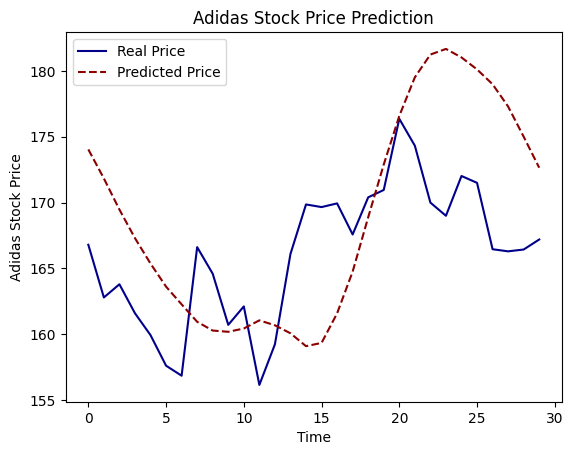

In [83]:
plt.plot(real_price,color = '#00008B', label = 'Real Price')
plt.plot(predicted_price, color = '#8B0000', linestyle='--', label = 'Predicted Price')
plt.title('Adidas Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Adidas Stock Price')
plt.legend()
plt.show()

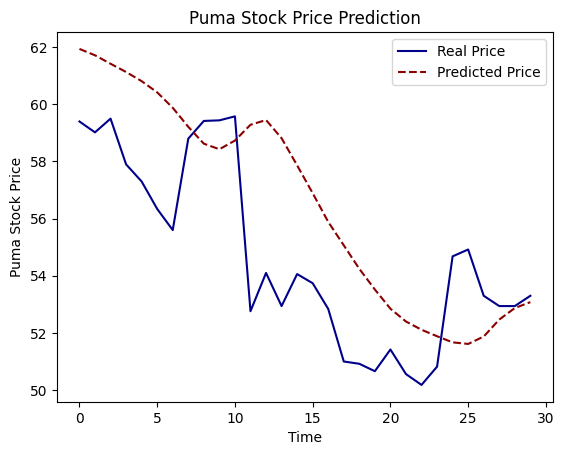

In [140]:
plt.plot(real_price,color = '#00008B', label = 'Real Price')
plt.plot(predicted_price, color = '#8B0000', linestyle='--', label = 'Predicted Price')
plt.title('Puma Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Puma Stock Price')
plt.legend()
plt.show()

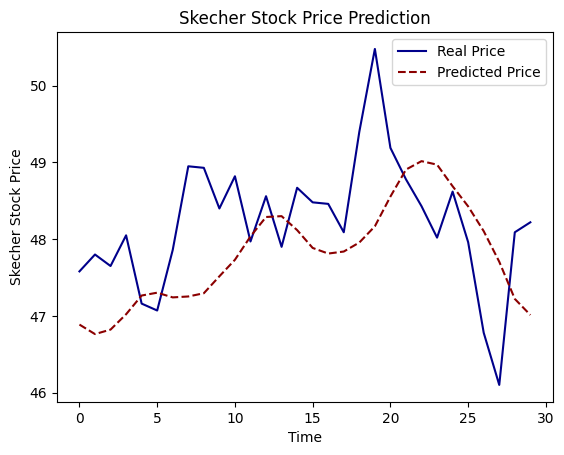

In [151]:
plt.plot(real_price,color = '#00008B', label = 'Real Price')
plt.plot(predicted_price, color = '#8B0000', linestyle='--', label = 'Predicted Price')
plt.title('Skecher Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Skecher Stock Price')
plt.legend()
plt.show()

From the graph and the RMSE, we can see that the simple RNN method does not really provide a better RMSE value than the ARIMA model. This is due to the fact that the ARIMA data has been log-transformed. But the superiority of the RNN model when comparing to the ARIMA model is the direction of the stock whereas the ARIMA model can only provide a scalar result because the ARIMA finds the stock price to be a random walk process.

# GAN-LSTM

In [96]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from keras.utils.vis_utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump

import warnings
warnings.filterwarnings("ignore")

In [97]:
train_test_ratio = 0.9

In [98]:
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')
ads_de = pd.read_csv("ADS.DE.csv",index_col="Date",parse_dates = ['Date'],date_parser=dateparse)
pum_de = pd.read_csv("PUM.DE.csv",index_col="Date",parse_dates = ['Date'],date_parser=dateparse)
skx = pd.read_csv("skx.csv",index_col="Date",parse_dates = ['Date'],date_parser=dateparse)

In [99]:
ads_de = ads_de.ffill(axis = 0)
pum_de = pum_de.ffill(axis = 0)
skx = skx.ffill(axis = 0)

In [100]:


def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema']-dataset['26ema']

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(window = 21).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Close']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    return dataset


In [101]:
stock_name = "ads_de"
data = get_technical_indicators(pum_de)
data = data.dropna()
#train_data,test_data = gen_data_split_train_test(data)
feature_list = ['Close','ma7', 'ma21',
       '26ema', '12ema', 'MACD', '20sd', 'upper_band', 'lower_band', 'ema',
       'momentum', 'log_momentum']
feature_list_wo_close = [ 'ma7', 'ma21',
       '26ema', '12ema', 'MACD', '20sd', 'upper_band', 'lower_band', 'ema',
       'momentum', 'log_momentum']
#train_set = train_data[feature_list]
features = len(feature_list)

In [102]:
X_value = data[feature_list]
y_value = data[['Close']]

In [103]:
# Normalized the data
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaler.fit(X_value)
y_scaler.fit(y_value)

MinMaxScaler(feature_range=(-1, 1))

In [104]:
X_scale_dataset = X_scaler.fit_transform(X_value)
y_scale_dataset = y_scaler.fit_transform(y_value)

In [105]:


def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index



In [106]:
batch_size = 5
predict_period = 1
X_batched, y_batched, yc = [],[],[]

for i in range(0,len(X_scale_dataset),1):
    x_val = X_scale_dataset[i: i + batch_size][:, :]
    y_val = y_scale_dataset[i + batch_size: i + batch_size + predict_period][:, 0]
    yc_val = y_scale_dataset[i: i + batch_size][:, :]
    if len(x_val) == batch_size and len(y_val) == predict_period:
        X_batched.append(x_val)
        y_batched.append(y_val)
        yc.append(yc_val)

X_batched, y_batched, yc = np.array(X_batched),np.array(y_batched),np.array(yc)

In [107]:
X_train, X_test = X_batched[:int(len(X_batched)*train_test_ratio)], X_batched[int(len(X_batched)*train_test_ratio):]
y_train, y_test = y_batched[:int(len(y_batched)*train_test_ratio)], y_batched[int(len(y_batched)*train_test_ratio):]
yc_train, yc_test = yc[:int(len(yc)*train_test_ratio)], yc[int(len(yc)*train_test_ratio):]
index_train, index_test, = predict_index(ads_de, X_train, batch_size, predict_period)

In [108]:
def make_generator_model(input_dim, output_dim, feature_size):
    model = tf.keras.Sequential([LSTM(units = 1024, return_sequences = True, 
                                    input_shape=(input_dim, feature_size),recurrent_dropout = 0.3),
                               LSTM(units = 512, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 256, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 64, recurrent_dropout = 0.3),
                               Dense(32),
                               Dense(16),
                               Dense(8),
                               Dense(units=output_dim)])
    return model

In [109]:
def make_discriminator_model(input_dim):
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(8, input_shape=(input_dim+1, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    #cnn_net.add(Flatten())
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

In [110]:
def discriminator_loss(real_output, fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = loss_f(tf.ones_like(fake_output), fake_output)
    return loss

In [111]:
@tf.function
def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = discriminator(d_real_input, training=True)
        fake_output = discriminator(d_fake_input, training=True)

        g_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': g_loss}

In [112]:
def train(real_x, real_y, yc, Epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint = 50):
    train_info = {}
    train_info["discriminator_loss"] = []
    train_info["generator_loss"] = []

    for epoch in tqdm(range(Epochs)):
        real_price, fake_price, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
        G_losses = []
        D_losses = []
        Real_price = []
        Predicted_price = []
        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())
        Predicted_price.append(fake_price.numpy())
        Real_price.append(real_price.numpy())

        #Save model every X checkpoints
        if (epoch + 1) % checkpoint == 0:
            tf.keras.models.save_model(generator, f'./models_gan/{stock_name}/generator_V_%d.h5' % epoch)
            tf.keras.models.save_model(discriminator, f'./models_gan/{stock_name}/discriminator_V_%d.h5' % epoch)
            print('epoch', epoch + 1, 'discriminator_loss', loss['d_loss'].numpy(), 'generator_loss', loss['g_loss'].numpy())
    
        train_info["discriminator_loss"].append(D_losses)
        train_info["generator_loss"].append(G_losses)
  
    Predicted_price = np.array(Predicted_price)
    Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
    Real_price = np.array(Real_price)
    Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

    plt.subplot(2,1,1)
    plt.plot(train_info["discriminator_loss"], label='Disc_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Discriminator Loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(train_info["generator_loss"], label='Gen_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Generator Loss')
    plt.legend()

    plt.show()

    return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

In [113]:
input_dim = X_train.shape[1] 
features = X_train.shape[2] 
output_dim = y_train.shape[1]

learning_rate = 5e-4
epochs = 500

g_optimizer = tf.keras.optimizers.Adam(lr = learning_rate)
d_optimizer = tf.keras.optimizers.Adam(lr = learning_rate)

generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = make_discriminator_model(X_train.shape[1])

 10%|████                                      | 49/500 [01:10<09:18,  1.24s/it]

 10%|████▏                                     | 50/500 [01:12<09:34,  1.28s/it]

epoch 50 discriminator_loss 1.35512 generator_loss 0.68412954


 20%|████████▎                                 | 99/500 [02:10<07:59,  1.20s/it]

 20%|████████▏                                | 100/500 [02:12<08:00,  1.20s/it]

epoch 100 discriminator_loss 1.406102 generator_loss 0.68568933


 30%|████████████▏                            | 149/500 [03:12<07:30,  1.28s/it]

 30%|████████████▎                            | 150/500 [03:14<07:31,  1.29s/it]

epoch 150 discriminator_loss 1.3885133 generator_loss 0.697536


 40%|████████████████▎                        | 199/500 [04:18<06:31,  1.30s/it]

 40%|████████████████▍                        | 200/500 [04:19<06:30,  1.30s/it]

epoch 200 discriminator_loss 1.3919888 generator_loss 0.7545073


 50%|████████████████████▍                    | 249/500 [05:26<05:25,  1.30s/it]

 50%|████████████████████▌                    | 250/500 [05:27<05:29,  1.32s/it]

epoch 250 discriminator_loss 1.3906512 generator_loss 0.6888011


 60%|████████████████████████▌                | 299/500 [06:37<04:45,  1.42s/it]

 60%|████████████████████████▌                | 300/500 [06:39<04:38,  1.39s/it]

epoch 300 discriminator_loss 1.3875792 generator_loss 0.6914325


 70%|████████████████████████████▌            | 349/500 [07:55<04:16,  1.70s/it]

 70%|████████████████████████████▋            | 350/500 [07:57<04:25,  1.77s/it]

epoch 350 discriminator_loss 1.3873873 generator_loss 0.69257355


 80%|████████████████████████████████▋        | 399/500 [09:22<02:44,  1.63s/it]

 80%|████████████████████████████████▊        | 400/500 [09:27<04:17,  2.58s/it]

epoch 400 discriminator_loss 1.3864131 generator_loss 0.69052076


 90%|████████████████████████████████████▊    | 449/500 [10:44<01:15,  1.49s/it]

 90%|████████████████████████████████████▉    | 450/500 [10:45<01:15,  1.52s/it]

epoch 450 discriminator_loss 1.3859599 generator_loss 0.6995853


100%|████████████████████████████████████████▉| 499/500 [11:57<00:01,  1.36s/it]

100%|█████████████████████████████████████████| 500/500 [12:00<00:00,  1.44s/it]

epoch 500 discriminator_loss 1.3864856 generator_loss 0.69222504


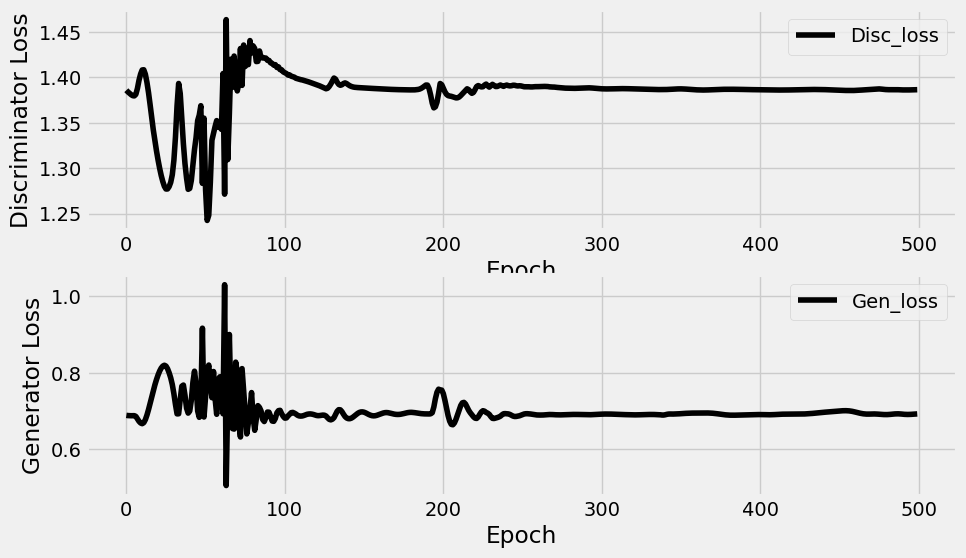

In [114]:
predicted_price, real_price, RMSPE = train(X_train, y_train, yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer)

In [115]:
test_generator = tf.keras.models.load_model(f'./models_gan/{stock_name}/generator_V_{epochs-1}.h5')

In [116]:
## Test Code

@tf.function 
def eval_op(generator, real_x):
    generated_data = generator(real_x, training = False)

    return generated_data

In [117]:
predicted_test_data = eval_op(test_generator, X_test)
#predicted_test_data = sc_single.inverse_transform(predicted_test_data)

In [118]:
forecast_dfs = X_value[-30:][feature_list].reset_index()
for i in range(30):
    forecast_input = np.concatenate([sc.fit_transform(forecast_dfs[feature_list_wo_close]),sc_single.fit_transform(forecast_dfs[['Close']])],axis=1)
    forecast_input = forecast_input[-batch_size:]
    forecast_inputs = []
    forecast_inputs.append(forecast_input)
    forecast_inputs = np.array(forecast_inputs)
    predicted_price = regressor.predict(forecast_inputs)
    predicted_price = sc_single.inverse_transform(predicted_price)
    # Create empty DataFrame with empty rows
    new_date = (forecast_dfs['Date'][-1:] + timedelta(days=1)).values[0]
    empty_data = {col: [''] for col in forecast_dfs.columns}
    empty_df = pd.DataFrame(empty_data)
    forecast_dfs = pd.concat([forecast_dfs,empty_df])
    # Fill in new row
    forecast_dfs.iloc[-1,0] = pd.Timestamp(new_date)
    forecast_dfs.iloc[-1,1] = predicted_price[0][0]
    forecast_dfs.iloc[-1,2] = forecast_dfs['Close'].rolling(window=7).mean()[-1:].values[0]
    forecast_dfs.iloc[-1,3] = forecast_dfs['Close'].rolling(window=21).mean()[-1:].values[0]
    forecast_dfs.iloc[-1,4] = forecast_dfs['Close'].ewm(span=26).mean()[-1:].values[0]
    forecast_dfs.iloc[-1,5] = forecast_dfs['Close'].ewm(span=12).mean()[-1:].values[0]
    forecast_dfs['MACD'] = forecast_dfs['12ema']-forecast_dfs['26ema']
    forecast_dfs.iloc[-1,7] = forecast_dfs['Close'].rolling(window = 21).std()[-1:].values[0]
    forecast_dfs['upper_band'] = forecast_dfs['ma21'] + (forecast_dfs['20sd']*2)
    forecast_dfs['lower_band'] = forecast_dfs['ma21'] - (forecast_dfs['20sd']*2)
    forecast_dfs.iloc[-1,10] = forecast_dfs['Close'].ewm(com=0.5).mean()[-1:].values[0]
    forecast_dfs['momentum'] = forecast_dfs['Close']-1
    forecast_dfs['log_momentum'] = np.log(forecast_dfs['momentum'].astype('float'))

forecast_price = forecast_dfs.iloc[-30:,0:2]

1/1 [==============================] - 0s 8ms/step


RMSE:  2.5412224424415775
MSE: 6.457811501968736
MAE: 2.093225779927055


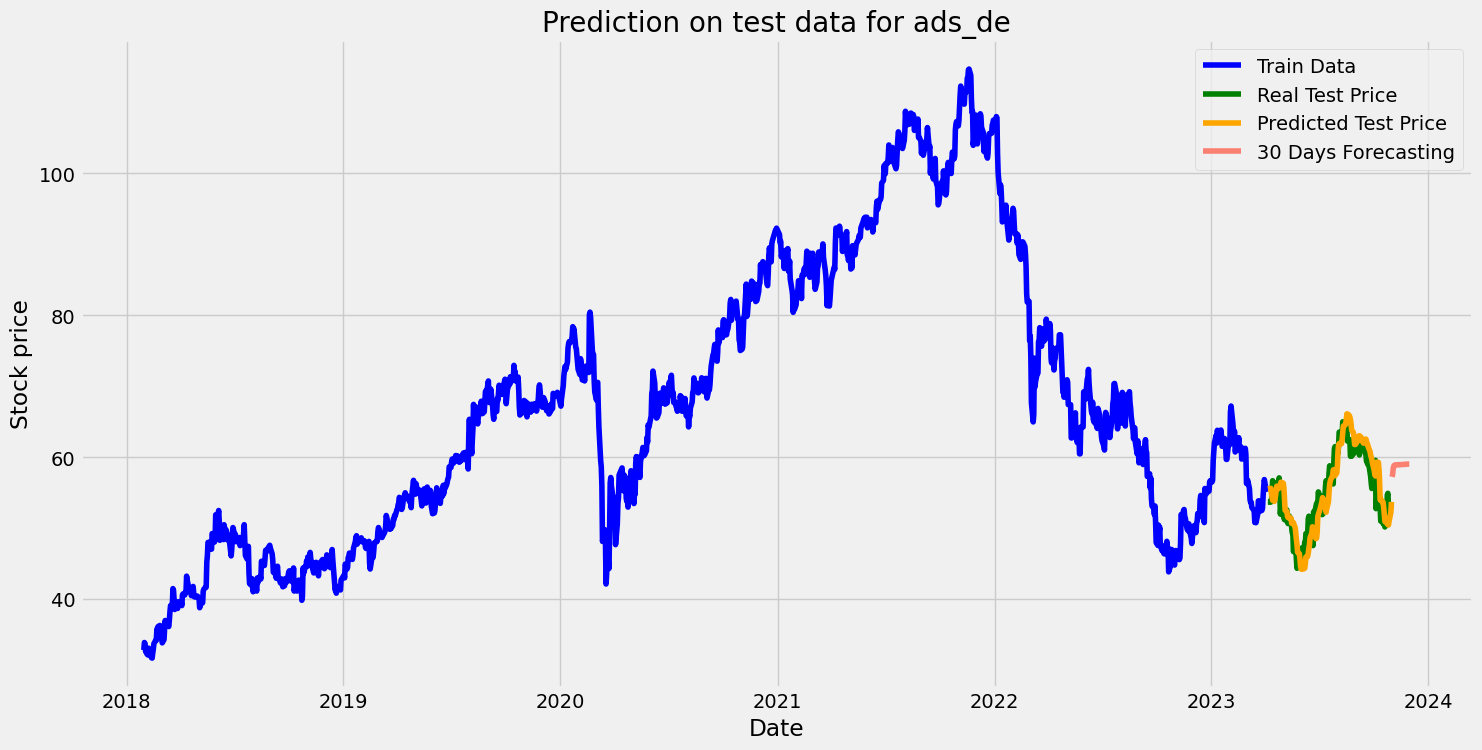

In [122]:
#ADS_DE
test_predict_index = index_test
rescaled_Real_price = y_scaler.inverse_transform(y_test)
rescaled_Predicted_price = y_scaler.inverse_transform(predicted_test_data)

predict_result = pd.DataFrame(rescaled_Predicted_price,columns = ['PredictedPrice'],index=test_predict_index[-len(rescaled_Predicted_price):])

real_price = pd.DataFrame(rescaled_Real_price,columns = ['RealPrice'],index=test_predict_index[-len(rescaled_Predicted_price):])

predicted = predict_result["PredictedPrice"]
real = real_price["RealPrice"]
For_MSE = pd.concat([predicted, real], axis = 1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('RMSE: ', RMSE)
mse = mean_squared_error(predicted, real)
print('MSE: '+str(mse))
mae = mean_absolute_error(predicted, real)
print('MAE: '+str(mae))

plt.figure(figsize=(16, 8))
plt.plot()
plt.plot(y_value.index[:int(len(y_value)*train_test_ratio)], y_value.Close[:int(len(y_value)*train_test_ratio)], label = "Train Data", color = "b")
plt.plot(real_price["RealPrice"], color='Green',label = 'Real Test Price')
plt.plot(predict_result["PredictedPrice"], color = 'Orange',label = "Predicted Test Price")
plt.plot(forecast_price.Date,forecast_price.Close, label = "30 Days Forecasting",color = "salmon")
plt.xlabel("Date")
plt.ylabel("Stock price")
#plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.legend()
plt.title(f"Prediction on test data for {stock_name}", fontsize=20)
plt.show()


RMSE:  2.5412224424415775
MSE: 6.457811501968736
MAE: 2.093225779927055


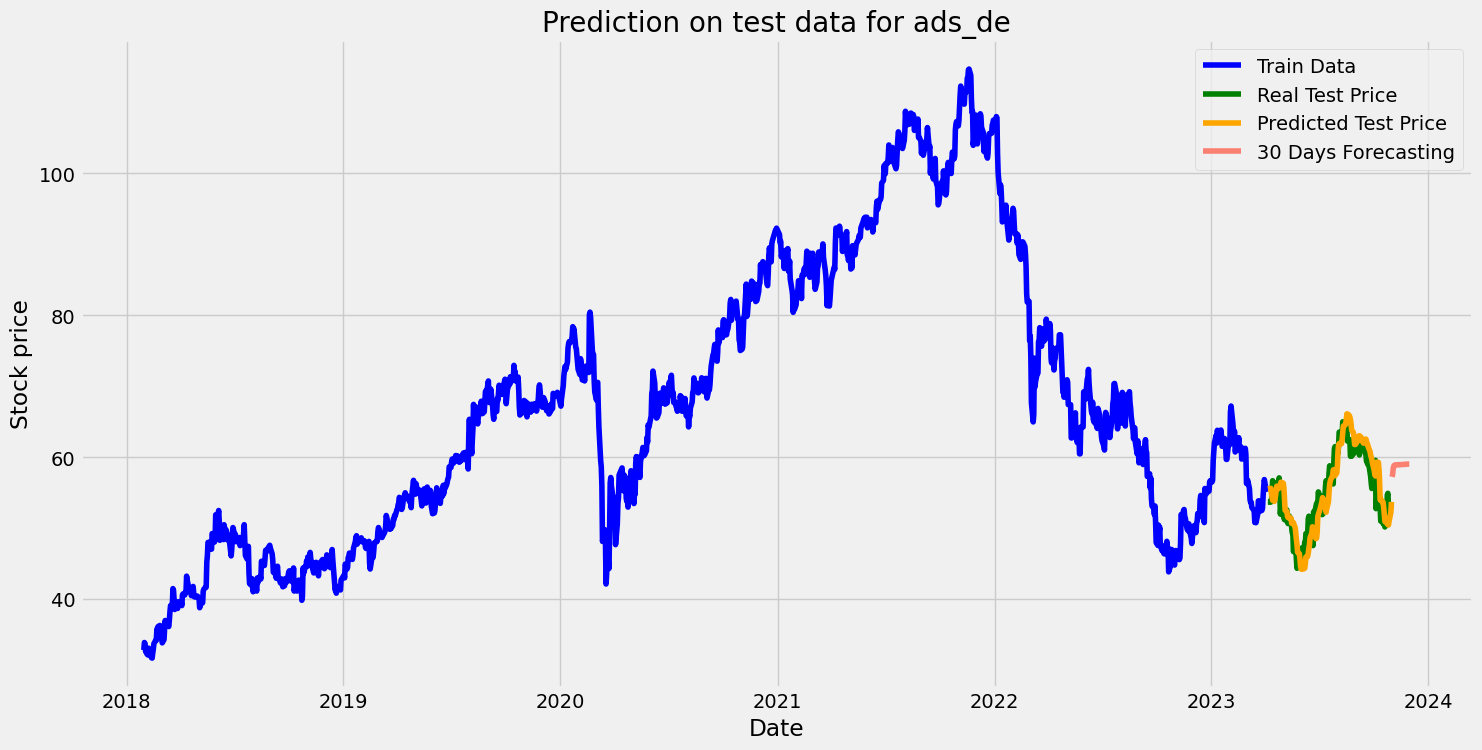

In [120]:
#PUM_DE
test_predict_index = index_test
rescaled_Real_price = y_scaler.inverse_transform(y_test)
rescaled_Predicted_price = y_scaler.inverse_transform(predicted_test_data)

predict_result = pd.DataFrame(rescaled_Predicted_price,columns = ['PredictedPrice'],index=test_predict_index[-len(rescaled_Predicted_price):])

real_price = pd.DataFrame(rescaled_Real_price,columns = ['RealPrice'],index=test_predict_index[-len(rescaled_Predicted_price):])

predicted = predict_result["PredictedPrice"]
real = real_price["RealPrice"]
For_MSE = pd.concat([predicted, real], axis = 1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('RMSE: ', RMSE)
mse = mean_squared_error(predicted, real)
print('MSE: '+str(mse))
mae = mean_absolute_error(predicted, real)
print('MAE: '+str(mae))

plt.figure(figsize=(16, 8))
plt.plot()
plt.plot(y_value.index[:int(len(y_value)*train_test_ratio)], y_value.Close[:int(len(y_value)*train_test_ratio)], label = "Train Data", color = "b")
plt.plot(real_price["RealPrice"], color='Green',label = 'Real Test Price')
plt.plot(predict_result["PredictedPrice"], color = 'Orange',label = "Predicted Test Price")
plt.plot(forecast_price.Date,forecast_price.Close, label = "30 Days Forecasting",color = "salmon")
plt.xlabel("Date")
plt.ylabel("Stock price")
#plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.legend()
plt.title(f"Prediction on test data for {stock_name}", fontsize=20)
plt.show()


RMSE:  2.5412224424415775
MSE: 6.457811501968736
MAE: 2.093225779927055


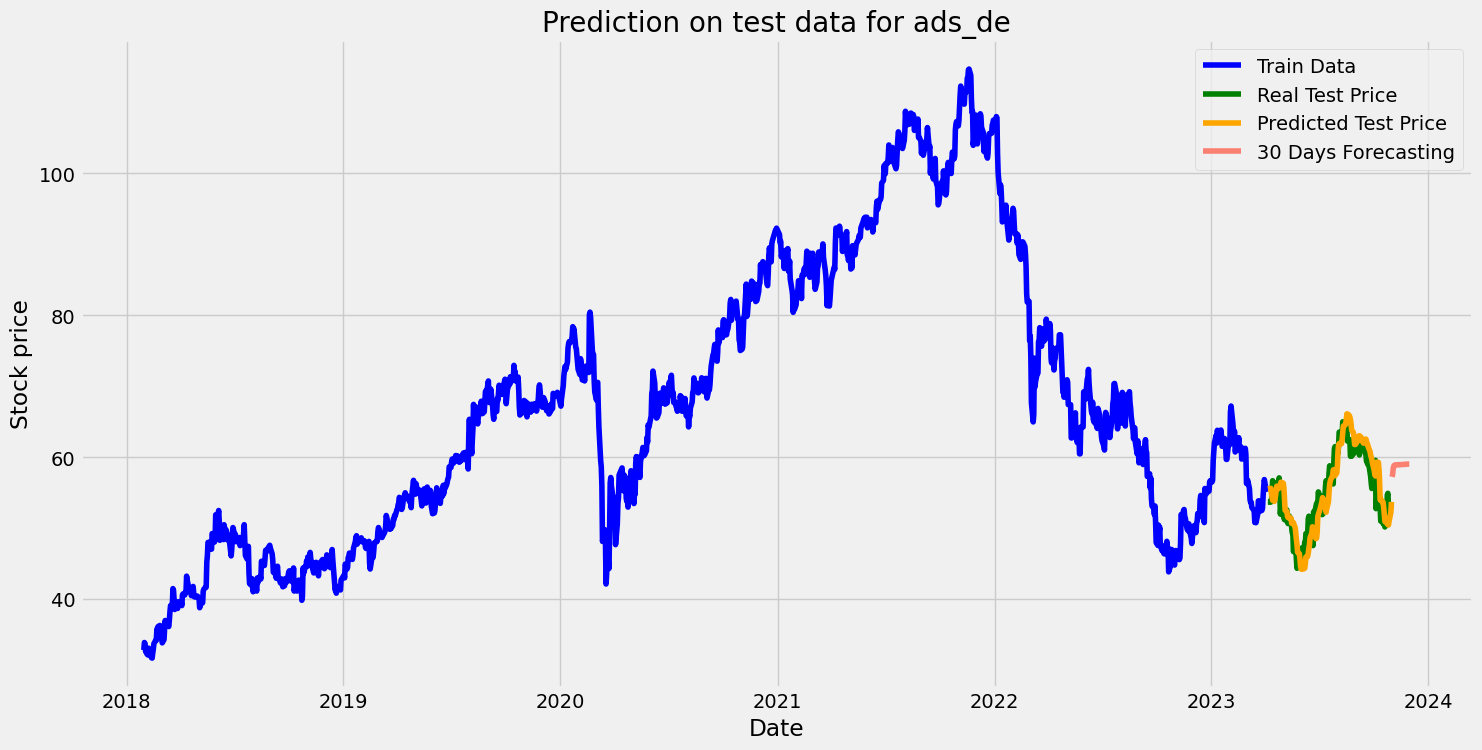

In [123]:
#ADS_DE
test_predict_index = index_test
rescaled_Real_price = y_scaler.inverse_transform(y_test)
rescaled_Predicted_price = y_scaler.inverse_transform(predicted_test_data)

predict_result = pd.DataFrame(rescaled_Predicted_price,columns = ['PredictedPrice'],index=test_predict_index[-len(rescaled_Predicted_price):])

real_price = pd.DataFrame(rescaled_Real_price,columns = ['RealPrice'],index=test_predict_index[-len(rescaled_Predicted_price):])

predicted = predict_result["PredictedPrice"]
real = real_price["RealPrice"]
For_MSE = pd.concat([predicted, real], axis = 1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('RMSE: ', RMSE)
mse = mean_squared_error(predicted, real)
print('MSE: '+str(mse))
mae = mean_absolute_error(predicted, real)
print('MAE: '+str(mae))

plt.figure(figsize=(16, 8))
plt.plot()
plt.plot(y_value.index[:int(len(y_value)*train_test_ratio)], y_value.Close[:int(len(y_value)*train_test_ratio)], label = "Train Data", color = "b")
plt.plot(real_price["RealPrice"], color='Green',label = 'Real Test Price')
plt.plot(predict_result["PredictedPrice"], color = 'Orange',label = "Predicted Test Price")
plt.plot(forecast_price.Date,forecast_price.Close, label = "30 Days Forecasting",color = "salmon")
plt.xlabel("Date")
plt.ylabel("Stock price")
#plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.legend()
plt.title(f"Prediction on test data for {stock_name}", fontsize=20)
plt.show()

RMSE:  2.9118475252264715
MSE: 8.478856010167526
MAE: 2.3348494441224883


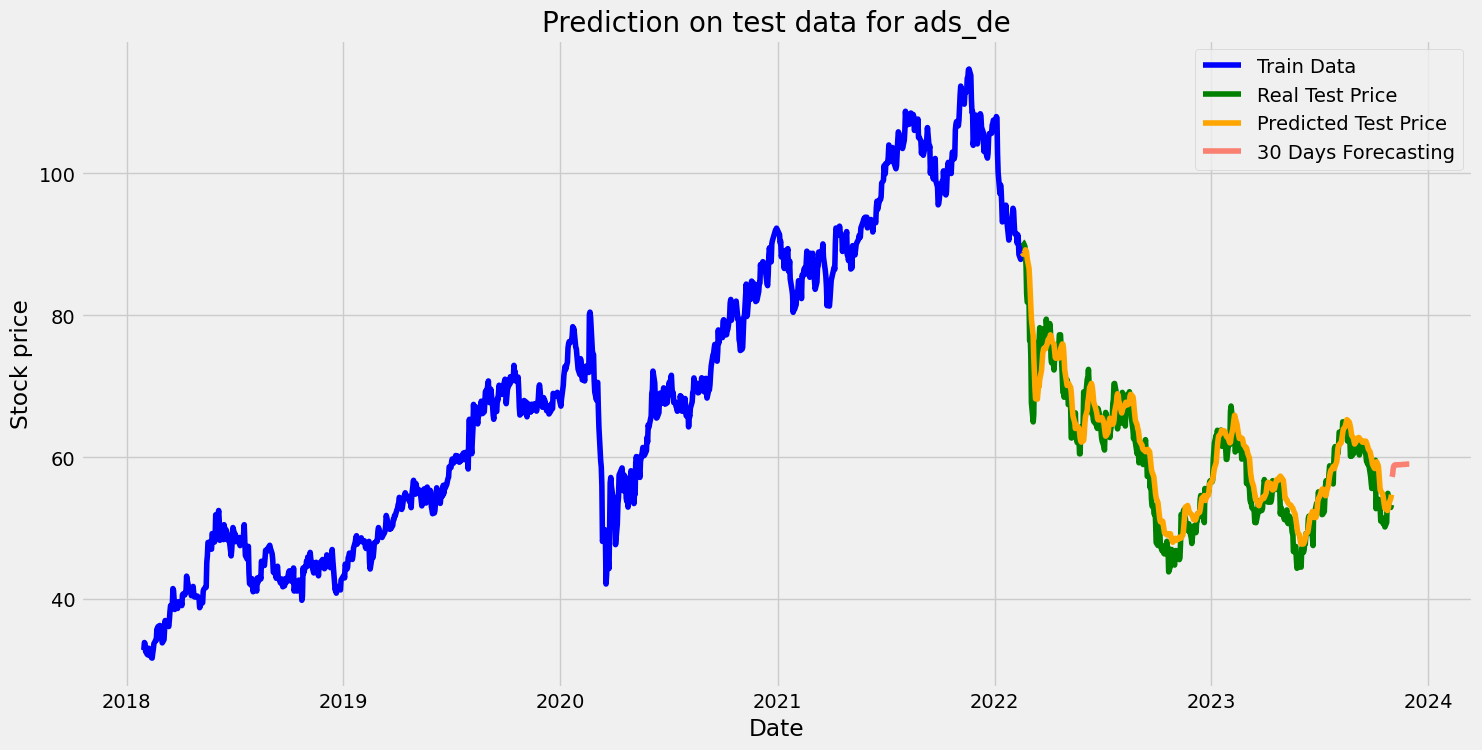

In [93]:
#SKX
test_predict_index = index_test
rescaled_Real_price = y_scaler.inverse_transform(y_test)
rescaled_Predicted_price = y_scaler.inverse_transform(predicted_test_data)

predict_result = pd.DataFrame(rescaled_Predicted_price,columns = ['PredictedPrice'],index=test_predict_index[-len(rescaled_Predicted_price):])

real_price = pd.DataFrame(rescaled_Real_price,columns = ['RealPrice'],index=test_predict_index[-len(rescaled_Predicted_price):])

predicted = predict_result["PredictedPrice"]
real = real_price["RealPrice"]
For_MSE = pd.concat([predicted, real], axis = 1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('RMSE: ', RMSE)
mse = mean_squared_error(predicted, real)
print('MSE: '+str(mse))
mae = mean_absolute_error(predicted, real)
print('MAE: '+str(mae))

plt.figure(figsize=(16, 8))
plt.plot()
plt.plot(y_value.index[:int(len(y_value)*train_test_ratio)], y_value.Close[:int(len(y_value)*train_test_ratio)], label = "Train Data", color = "b")
plt.plot(real_price["RealPrice"], color='Green',label = 'Real Test Price')
plt.plot(predict_result["PredictedPrice"], color = 'Orange',label = "Predicted Test Price")
plt.plot(forecast_price.Date,forecast_price.Close, label = "30 Days Forecasting",color = "salmon")
plt.xlabel("Date")
plt.ylabel("Stock price")
#plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.legend()
plt.title(f"Prediction on test data for {stock_name}", fontsize=20)
plt.show()


RMSE:  2.9118475252264715
MSE: 8.478856010167526
MAE: 2.3348494441224883


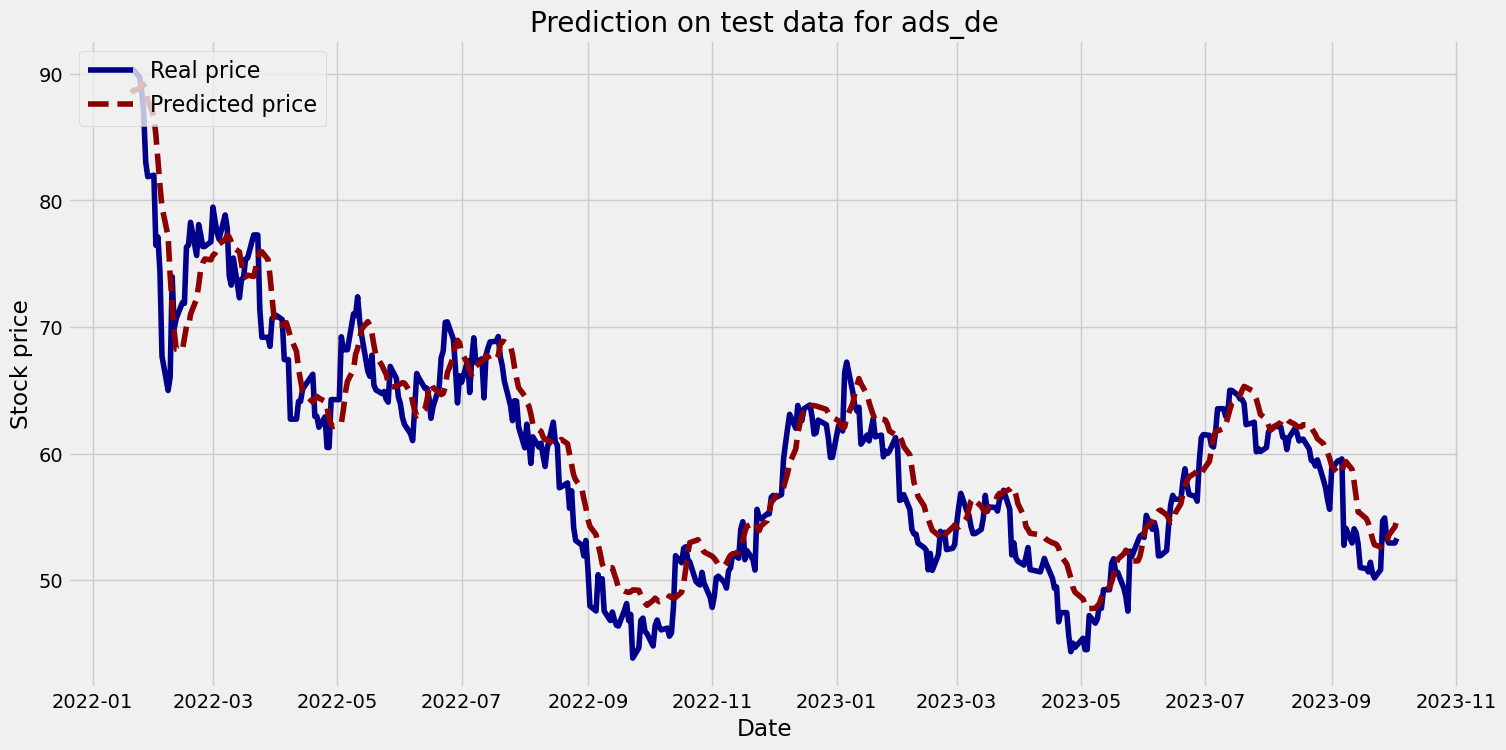

In [94]:
#pum_de
test_predict_index = index_test
rescaled_Real_price = y_scaler.inverse_transform(y_test)
rescaled_Predicted_price = y_scaler.inverse_transform(predicted_test_data)

predict_result = pd.DataFrame()
for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

real_price = pd.DataFrame()
for i in range(rescaled_Real_price.shape[0]):
    y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

predict_result['predicted_mean'] = predict_result.mean(axis=1)
real_price['real_mean'] = real_price.mean(axis=1)

predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis = 1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('RMSE: ', RMSE)
mse = mean_squared_error(predicted, real)
print('MSE: '+str(mse))
mae = mean_absolute_error(predicted, real)
print('MAE: '+str(mae))

plt.figure(figsize=(16, 8))
plt.plot(real_price["real_mean"], color='#00008B')
plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.title(f"Prediction on test data for {stock_name}", fontsize=20)
plt.show()

RMSE:  2.9118475252264715
MSE: 8.478856010167526
MAE: 2.3348494441224883


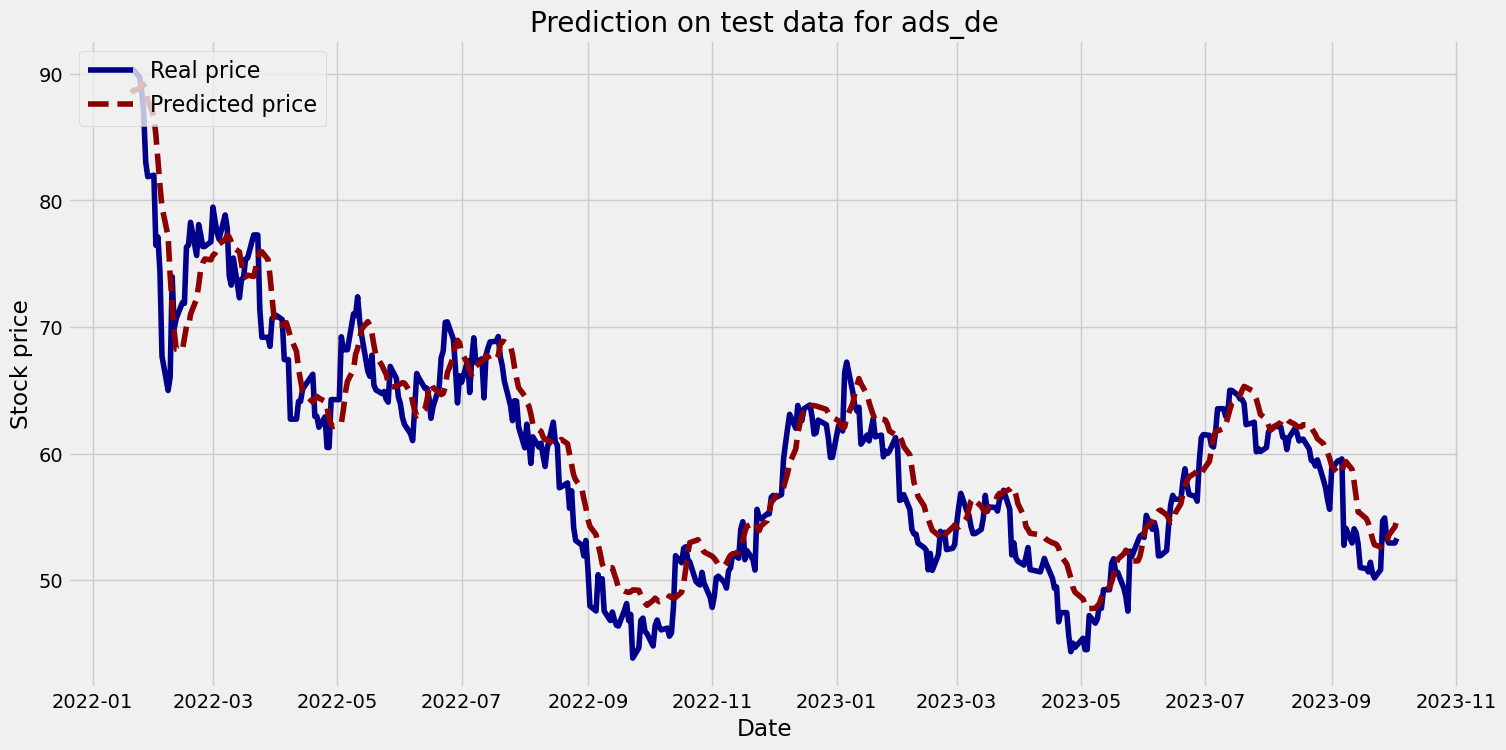

In [95]:
#skx
test_predict_index = index_test
rescaled_Real_price = y_scaler.inverse_transform(y_test)
rescaled_Predicted_price = y_scaler.inverse_transform(predicted_test_data)

predict_result = pd.DataFrame()
for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

real_price = pd.DataFrame()
for i in range(rescaled_Real_price.shape[0]):
    y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

predict_result['predicted_mean'] = predict_result.mean(axis=1)
real_price['real_mean'] = real_price.mean(axis=1)

predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis = 1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('RMSE: ', RMSE)
mse = mean_squared_error(predicted, real)
print('MSE: '+str(mse))
mae = mean_absolute_error(predicted, real)
print('MAE: '+str(mae))

plt.figure(figsize=(16, 8))
plt.plot(real_price["real_mean"], color='#00008B')
plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.title(f"Prediction on test data for {stock_name}", fontsize=20)
plt.show()

By using the GAN-LSTM model, we got a better RMSE in Adidas and Puma stock and a worse RMSE in Skecher when comparing with RNN. Moreover, when comparing with ARIMA we also got the direction of our prediction rather than a constant value due to the fact that the ARIMA model treated all three stock prices to be a random walk process.